# Modelo tradicional: tf-idf y PCA

Este notebook consiste en general la matriz de tf-idf y realizar un análisis de componentes principales (PCA) para usar estos como inputs en la red neuronal de clasificación.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

D:\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ng_20 = pd.read_csv('20newsgroups_all.csv')

ng_20.head()

,id_documento,Grupo,Documento,Target
0,54367,rec.sport.hockey,basher pen fan pretty confused lack kind post ...,10
1,60215,comp.sys.ibm.pc.hardware,brother market high performance video card sup...,3
2,76120,talk.politics.mideast,finally dream mediterranean area great year ho...,17
3,60771,comp.sys.ibm.pc.hardware,scsi card dma transfer disk scsi card dma tran...,3
4,51882,comp.sys.mac.hardware,jasmine drive understanding upsate driver mode...,4


In [3]:
set(ng_20['Grupo'])

{'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'}

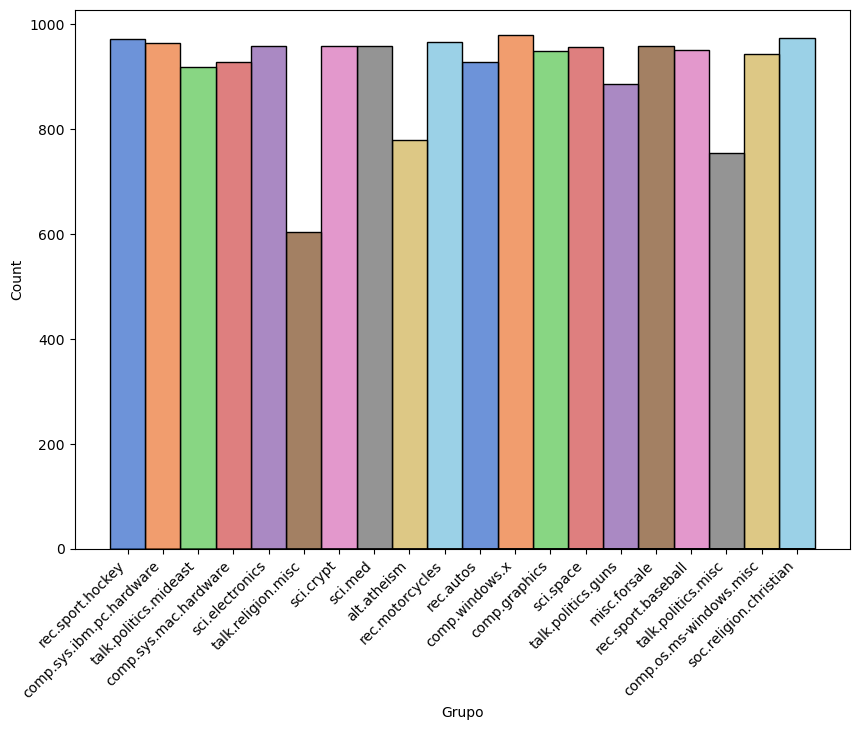

In [26]:
plt.figure(figsize=(10,7))
sns.histplot(data=ng_20, x='Grupo', hue='Grupo', alpha=.8, legend=False, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.show()

In [8]:
ng_20.groupby('Grupo').size().reset_index(name='n').sort_values(by='n')

,Grupo,n
19,talk.religion.misc,603
18,talk.politics.misc,753
0,alt.atheism,778
16,talk.politics.guns,885
17,talk.politics.mideast,917
4,comp.sys.mac.hardware,927
7,rec.autos,928
2,comp.os.ms-windows.misc,942
1,comp.graphics,948
9,rec.sport.baseball,949


Vamos a definir las funciones para el tf-idf y PCA

In [4]:
def tfidf(df):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matriz = tfidf_vectorizer.fit_transform(df['Documento'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return pd.DataFrame(tfidf_matriz.toarray(), columns=feature_names), tfidf_vectorizer

In [5]:
from sklearn.decomposition import PCA

def pca(matriz_tfidf, n_max=None, graf=False, estandarizada=False):
        
    if n_max == None:
        pca_train = PCA()
    else:
        pca_train = PCA(n_components=n_max)
        
    pca_train.fit(matriz_tfidf)
    
    varianza_explicada = pca_train.explained_variance_
    #var_explicada_acum = np.cumsum(varianza_explicada)
    
    #kaiser = next((i for i, val in enumerate(varianza_explicada) if val >= 1), np.nan) if estandarizada else np.nan
    kaiser = np.sum(varianza_explicada > 1)
    
    #var_80 = next((i for i, val in enumerate(var_explicada_acum) if val >= 0.8), None)
    
    if graf: 
        
        data = {
        'Componente principal': range(1, 21),
        'Varianza explicada': varianza_explicada[:20]
        }
        df = pd.DataFrame(data)

        plt.figure(figsize=(8, 6))
        sns.lineplot(x='Componente principal', y='Varianza explicada', data=df, marker='o')
        plt.title('Varianza explicada por componente')
        plt.xlabel('Componente principal')
        plt.ylabel('Varianza explicada')
        plt.grid(True)
        plt.show()
    
    return pca_train, kaiser

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

class red:
    def __init__(self, input_dim, hidden_units, output_units, activation, epochs, batch_size, callbacks):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.output_units = output_units
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.callbacks = callbacks
        self.model = self._build_model()

    def _build_model(self):
        
        if type(self.hidden_units) == int:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(self.hidden_units, activation='relu', input_shape=(self.input_dim,)),
                tf.keras.layers.Dense(self.output_units, activation=self.activation)
            ])
        else:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(self.hidden_units[0], activation='relu', input_shape=(self.input_dim,)),
                tf.keras.layers.Dense(self.hidden_units[1], activation='relu'),
                tf.keras.layers.Dense(self.output_units, activation=self.activation)
            ])
            
        return model

    def compilar(self, f_perdida, optimizer='adam', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=f_perdida, metrics=metrics)

    def entrenar(self, x_train, y_train, validation_data):
        self.model.fit(x_train, y_train, validation_data=validation_data, epochs=self.epochs, batch_size=self.batch_size, verbose=0, callbacks=self.callbacks)

    def evaluar(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)
    
    def predecir(self, x_test):
        return self.model.predict(x_test)
    
    def reentrenar(self, x_train, y_train):
        parada = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        self.model.fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0, callbacks=parada)


In [7]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

def modelaje_pca(X, y, hidden_units = [128, 64], epochs=100, batch_size=128, parar=True, show=False):
    
    if type(y[0])==np.int64:
        n = 1
        f_perdida = 'binary_crossentropy'
        activacion = 'sigmoid'
    else:
        n = len(y[0])
        f_perdida = 'categorical_crossentropy'
        activacion = 'softmax'
        
    input_dim = X.shape[1]
    
    X_tensor = np.asarray([tf.constant(arr) for arr in X])
    y_tensor = np.asarray([tf.constant(arr) for arr in y])
    
    parada = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) if parar else 'None'
    
    kfold = KFold(n_splits=4, shuffle=True, random_state=2808)

    accuracies = []
    
    
    for train_index, val_index in kfold.split(X_tensor):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]

        modelo = red(input_dim = input_dim, hidden_units = hidden_units, output_units=n, activation=activacion, epochs=epochs, batch_size=batch_size, callbacks=[parada])
        modelo.compilar(f_perdida=f_perdida)
        modelo.entrenar(X_train, y_train, validation_data=(X_val, y_val))

        loss, accuracy = modelo.evaluar(X_val, y_val)
        accuracies.append(accuracy) 
    
    if show:
        preds = modelo.predecir(X_val)
        
        if n == 1:
            cm = confusion_matrix(y_val, np.round(preds))
        else:
            cm = confusion_matrix([np.argmax(target) for target in y_val], [np.argmax(pred) for pred in preds])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
    #modelo.entrenar(X_tensor, y_tensor, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[parada])
    
    return(modelo, np.mean(accuracies))

In [8]:
def grid_search(X, y, pca_train, n_componentes=300, hidden_units = [[128, 64]], epochs=100, batch_sizes=128, resultados={}):
    
    X_train = pca_train.transform(X)[:, :n_componentes]
    for hidden_unit in hidden_units:
        for epoch in epochs:
            for batch_size in batch_sizes:
                print(f'Modelo con {n_componentes}, {hidden_unit}, {epoch}, {batch_size}')
                
                modelo, accuracy = modelaje_pca(X_train, y, hidden_unit, epoch, batch_size)
                print(accuracy*100)
                    
                if isinstance(hidden_unit, list):
                     resultados[(n_componentes, tuple(hidden_unit), epoch, batch_size)] = accuracy
                else:
                    resultados[(n_componentes, hidden_unit, epoch, batch_size)] = accuracy
                
    return resultados

In [9]:
from sklearn.metrics import accuracy_score

def comprobar(y_val, y_pred, graf=False):
   
    if type(y_val[0])==np.int64:
        y_pred = np.round(y_pred)
    else:
        y_val = [np.argmax(target) for target in y_val]
        y_pred = [np.argmax(pred) for pred in y_pred]
    cm = confusion_matrix(y_val, y_pred)
    if graf:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicho')
        plt.ylabel('Verdadero')
        plt.title('Matriz de confusión')
        plt.show()
    
    return accuracy_score(y_val, y_pred), cm

In [10]:
def one_hot_encoding(target, n):
    vector = np.zeros(n)
    vector[target]= 1
    
    return vector

In [11]:
def modelaje_final(X_train, y_train, X_val, y_val, tfidf_train, pca_train, n_componentes, hidden_units, epochs, batch_size, graf=False):
    
    if type(y_train[0])==np.int64:
        n = 1
        f_perdida = 'binary_crossentropy'
        activacion = 'sigmoid'
    else:
        n = len(y_train[0])
        f_perdida = 'categorical_crossentropy'
        activacion = 'softmax'
        
    input_dim = X_train.shape[1]
    
    X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])
    
    
    parada = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    
    modelo = red(input_dim = input_dim, hidden_units = hidden_units, output_units=n, activation=activacion, epochs=epochs, batch_size=batch_size, callbacks=[parada])
    modelo.compilar(f_perdida=f_perdida)
    modelo.reentrenar(X_tensor, y_tensor)
    
    X_val = tfidf_train.transform(X_val['Documento'])
    X_val = pca_train.transform(X_val.toarray())[:,:n_componentes]
    
    X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])
    preds = modelo.predecir(X_val_tensor)
    
    if graf:
        acc, cm = comprobar(y_val, preds)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicho')
        plt.ylabel('Verdadero')
        plt.title('Matriz de confusión')
        return acc
        
    else:
        return(comprobar(y_val, preds))

In [12]:
def proceso_estandar(X_matriz, y_train, X_val, y_val, tfidf_train):
    
    hidden_units = [[64, 10], 100, [80, 20]]
    epochs=[80, 150]
    batch_sizes=[100, 200]
    
    precisiones = {}
    
    media = np.mean(X_matriz, axis=0)
    std = np.std(X_matriz, axis=0)

    X_estandar = (X_matriz-media)/std
    
    pca_train, kaiser = pca(X_estandar, graf=False, estandarizada=True)
    
        
    if kaiser > 0:
        #hidden_units = [int(np.ceil(kaiser/2)), int(kaiser*2)]
        resultados = grid_search(X_estandar, y_train, pca_train, kaiser, hidden_units, epochs, batch_sizes, resultados={})
        
        orden = dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))
        n, hidden_unit, epoch, batch_size = list(orden.keys())[0]
        
        X_kaiser = pca_train.transform(X_estandar)[:, :kaiser]
        acc_kaiser, cm_kaiser = modelaje_final(X_kaiser, y_train, X_val, y_val, tfidf_train, pca_train, kaiser, hidden_unit, epoch, batch_size)
        precisiones['Kaiser'] = acc_kaiser
    else:
        print('No se encontró Kaiser en las 300 primeras componentes')
        
    resultados = grid_search(X_estandar, y_train, pca_train, 300, hidden_units, epochs, batch_sizes, resultados={})
    
    orden = dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))
    n, hidden_unit, epoch, batch_size = list(orden.keys())[0]
        
    X_300 = pca_train.transform(X_estandar)[:, :300]
    acc_300, cm_300 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_train, pca_train, 300, hidden_unit, epoch, batch_size)
    precisiones['300'] = acc_300
    
    if kaiser == 0:
        
        sns.heatmap(cm_300, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for, n_componentes = 300')
            
    else:
        plt.figure(figsize=(12, 5))

        plt.subplot(1,2,1)
        sns.heatmap(cm_kaiser, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicho')
        plt.ylabel('Verdader')
        plt.title(f'Matriz de confusión, {kaiser} componentes')
        
        plt.subplot(1,2,2)
        sns.heatmap(cm_300, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicho')
        plt.ylabel('Verdader')
        plt.title('Matriz de confusión 300 componentes')
    
    return precisiones


In [41]:
ng_a4['Documento'].values[0]

'kirlian imaging faq sciskeptic nice write supportive build device connect kvolt supply aura'

In [58]:
def nube(documentos):
    lista = documentos.tolist()
    cadena = ' '.join(lista)
    
    wordcloud = WordCloud(max_words=50, background_color='white').generate(cadena)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [70]:
a = ng_a4['Documento'].values

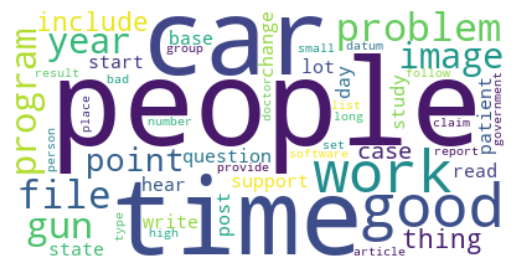

In [71]:
nube(a)

## Dos temas distintos: ateísmo vs autos

In [18]:
ng_ateauto = ng_20[ng_20['Grupo'].isin(['alt.atheism', 'rec.autos'])]

In [19]:
ng_ateauto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1706 entries, 14 to 18265
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  1706 non-null   int64 
 1   Grupo         1706 non-null   object
 2   Documento     1706 non-null   object
 3   Target        1706 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 66.6+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

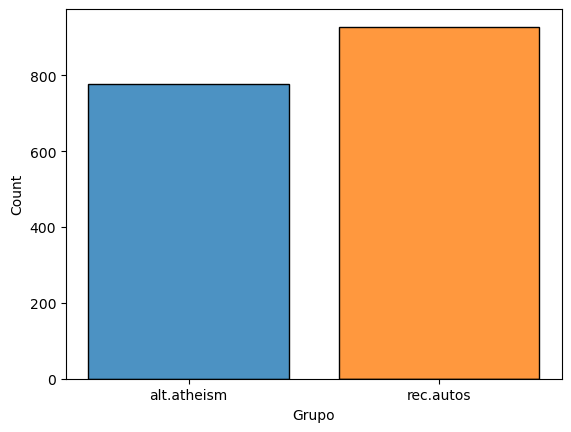

In [20]:
sns.histplot(data=ng_ateauto, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [21]:
ng_ateauto['Target'] = ng_ateauto['Target'].replace({7:1})

C:\Users\David\AppData\Local\Temp\ipykernel_11648\1905573322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ng_ateauto['Target'] = ng_ateauto['Target'].replace({7:1})


In [140]:
X, y = ng_ateauto.drop(['Target'],axis=1), ng_ateauto['Target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [141]:
len(X_train), len(X_val)

(1364, 342)

Text(0.5, 1.0, 'X_val')

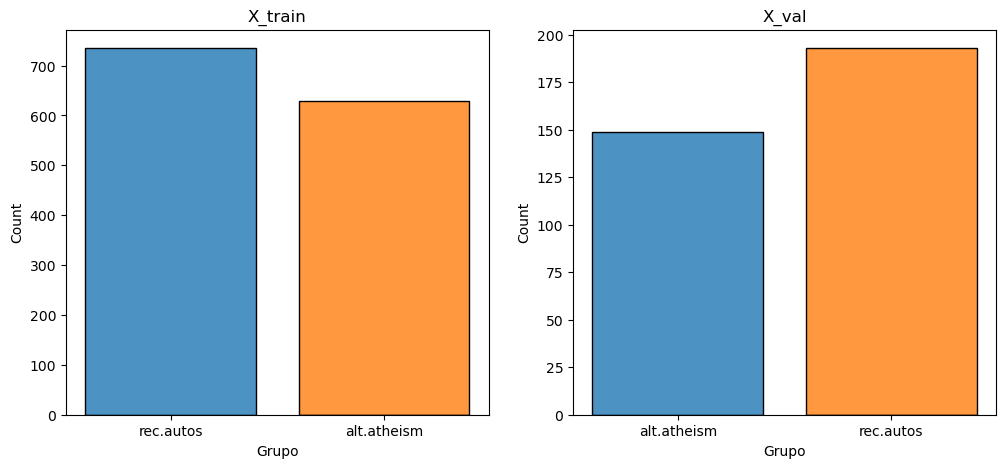

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [25]:
matriz_ateauto, tfidf_ateauto = tfidf(X_train)

matriz_ateauto.head()

,aaa,aah,aam,aamir,aap,abandon,abberation,abbie,abbreviation,abc,...,zionist,zip,zlumber,zombie,zone,zoo,zues,zur,zus,zx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
matriz_ateauto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364 entries, 0 to 1363
Columns: 11729 entries, aaa to zx
dtypes: float64(11729)
memory usage: 122.1 MB


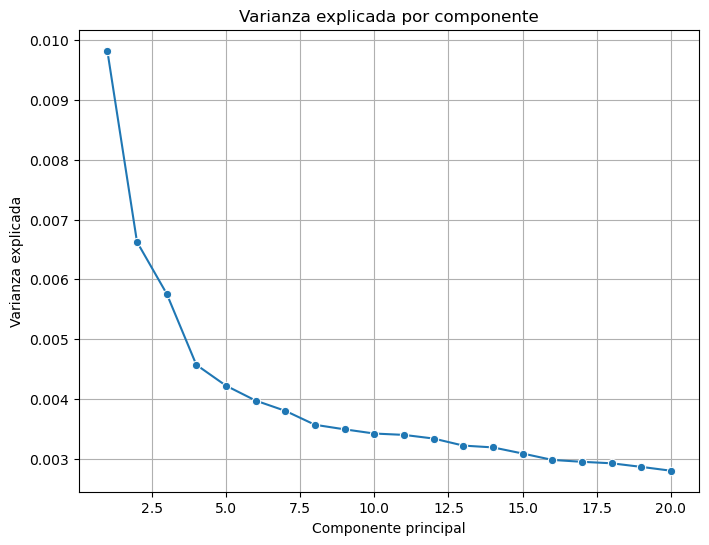

In [27]:
pca_ateauto, kaiser = pca(matriz_ateauto, graf=True)

N = 3

**Método del codo:** 3 Componentes 

In [28]:
n_componentes = 3
hidden_units = [3, 6]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados = grid_search(matriz_ateauto, y_train, pca_ateauto, n_componentes, hidden_units, epochs, batch_sizes, resultados={})

Modelo con 3, 3, 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.9267
87.31671571731567
Modelo con 3, 3, 80, 200
11/11 [==============================] - 0s 1ms/step - loss: 0.6620 - accuracy: 0.6628
78.07917892932892
Modelo con 3, 3, 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.9296
82.4780061841011
Modelo con 3, 3, 150, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.9413
91.05571806430817
Modelo con 3, 6, 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.4568 - accuracy: 0.9208
90.32258093357086
Modelo con 3, 6, 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.6067 - accuracy: 0.9238
80.71847558021545
Modelo con 3, 6, 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.2792 - accuracy: 0.9443
93.03519129753113
Modelo con 3, 6, 150, 200
11/11 [==============================] - 0s 2ms/step - loss: 0

In [29]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{(3, 6, 150, 100): 0.9303519129753113,
 (3, 6, 150, 200): 0.9237536787986755,
 (3, 3, 150, 200): 0.9105571806430817,
 (3, 6, 80, 100): 0.9032258093357086,
 (3, 3, 80, 100): 0.8731671571731567,
 (3, 3, 150, 100): 0.824780061841011,
 (3, 6, 80, 200): 0.8071847558021545,
 (3, 3, 80, 200): 0.7807917892932892}

 1/11 [=>............................] - ETA: 0s

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


11/11 [==============================] - 0s 1ms/step


0.9210526315789473

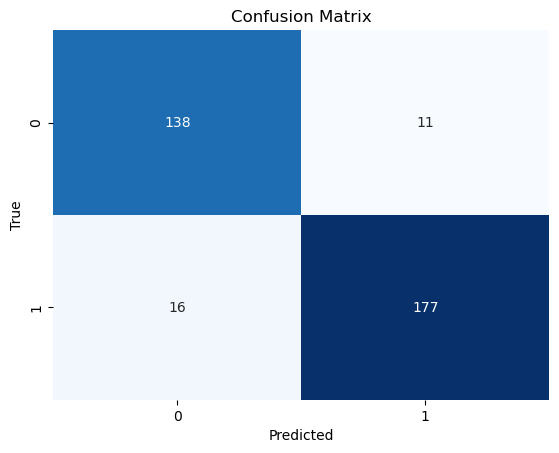

In [30]:
X_train = pca_ateauto.transform(matriz_ateauto)[:, :3]

acc_codo = modelaje_final(X_train, y_train, X_val, y_val, tfidf_ateauto, pca_ateauto, 3, 6, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [142]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados = grid_search(matriz_ateauto, y_train, pca_ateauto, n_componentes, hidden_units, epochs, batch_sizes, resultados={})

Modelo con 300, [64, 10], 80, 100
11/11 [==============================] - 0s 3ms/step - loss: 0.2634 - accuracy: 0.8915
89.80938345193863
Modelo con 300, [64, 10], 80, 200
11/11 [==============================] - 0s 3ms/step - loss: 0.2645 - accuracy: 0.8856
88.85630369186401
Modelo con 300, [64, 10], 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.2768 - accuracy: 0.8827
89.29618746042252
Modelo con 300, [64, 10], 150, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.2658 - accuracy: 0.8798
89.0029326081276
Modelo con 300, 100, 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.2893 - accuracy: 0.8739
88.19648027420044
Modelo con 300, 100, 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.2957 - accuracy: 0.8710
87.31671571731567
Modelo con 300, 100, 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.8768
88.34310919046402
Modelo con 300, 100, 150, 200
11/11 [===

In [143]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{(300, (64, 10), 80, 100): 0.8980938345193863,
 (300, (64, 10), 150, 100): 0.8929618746042252,
 (300, (80, 20), 80, 200): 0.8914956003427505,
 (300, (64, 10), 150, 200): 0.8900293260812759,
 (300, (80, 20), 150, 200): 0.8900293260812759,
 (300, (80, 20), 150, 100): 0.8900293111801147,
 (300, (80, 20), 80, 100): 0.8885630518198013,
 (300, (64, 10), 80, 200): 0.8885630369186401,
 (300, 100, 150, 100): 0.8834310919046402,
 (300, 100, 80, 100): 0.8819648027420044,
 (300, 100, 150, 200): 0.880498543381691,
 (300, 100, 80, 200): 0.8731671571731567}

Nos quedamos con el modelo de 6, [64,10], 150, 100

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


11/11 [==============================] - 0s 3ms/step


0.9269005847953217

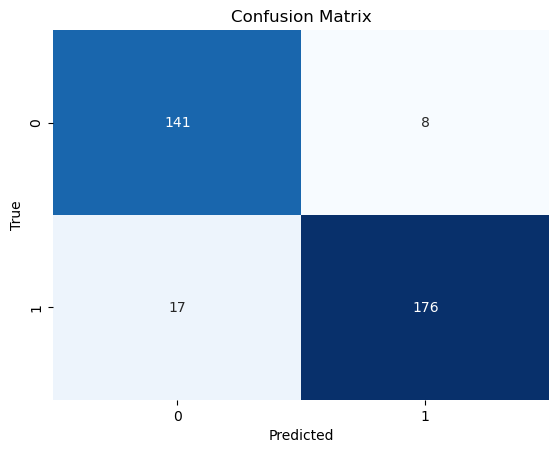

In [144]:
X_300 = pca_ateauto.transform(matriz_ateauto)[:, :300]
acc = modelaje_final(X_300, y_train, X_val, y_val, tfidf_ateauto, pca_ateauto, 300, [64,10], 80, 100, graf=True)
acc

### Estandarización

Modelo con 1295, [64, 10], 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.7012 - accuracy: 0.6422
62.9032239317894
Modelo con 1295, [64, 10], 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.7067
66.4222851395607
Modelo con 1295, [64, 10], 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.7214
67.7419364452362
Modelo con 1295, [64, 10], 150, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.7264 - accuracy: 0.6950
64.07624632120132
Modelo con 1295, 100, 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.8693 - accuracy: 0.7273
70.23460566997528
Modelo con 1295, 100, 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.7562 - accuracy: 0.7214
69.06158477067947
Modelo con 1295, 100, 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 1.1009 - accuracy: 0.7097
70.23460417985916
Modelo con 1295, 100, 150, 200
11/1

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Modelo con 300, [64, 10], 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.2800 - accuracy: 0.9208
91.05571806430817
Modelo con 300, [64, 10], 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.9150
90.68914949893951
Modelo con 300, [64, 10], 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.4137 - accuracy: 0.9062
89.51612710952759
Modelo con 300, [64, 10], 150, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.2597 - accuracy: 0.9150
90.1759535074234
Modelo con 300, 100, 80, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.9003
90.61583429574966
Modelo con 300, 100, 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.9238
92.30205416679382
Modelo con 300, 100, 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.2542 - accuracy: 0.9238
90.98240584135056
Modelo con 300, 100, 150, 200
11/11 [===

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


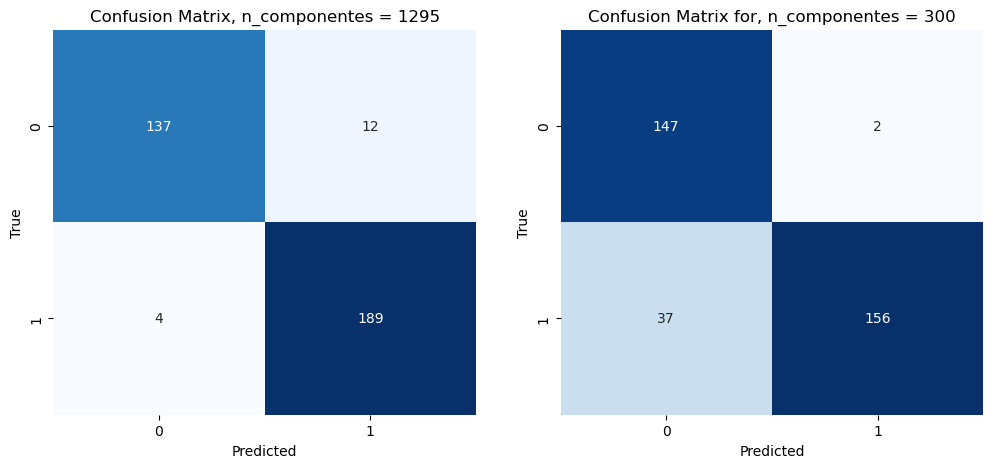

In [35]:
precisiones = proceso_estandar(matriz_ateauto, y_train, X_val, y_val, tfidf_ateauto)

In [36]:
precisiones

{'Kaiser': 0.9532163742690059, '300': 0.8859649122807017}

## Un tema de cada bloque

In [13]:
ng_a4 = ng_20[ng_20['Grupo'].isin(['comp.graphics', 'rec.autos', 'sci.med', 'talk.politics.guns'])]
ng_a4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3718 entries, 13 to 18265
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  3718 non-null   int64 
 1   Grupo         3718 non-null   object
 2   Documento     3718 non-null   object
 3   Target        3718 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 145.2+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

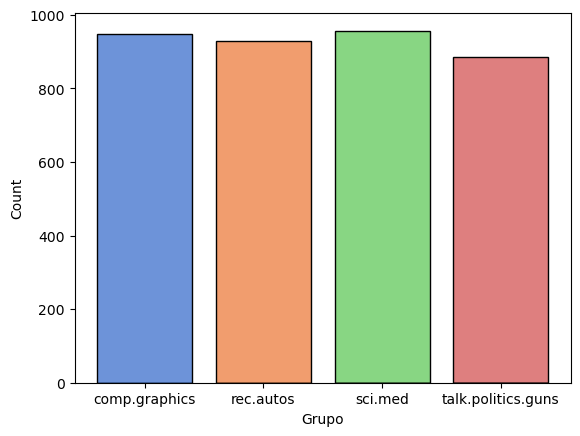

In [14]:
orden = ['comp.graphics', 'rec.autos', 'sci.med', 'talk.politics.guns']
ng_ordenada = ng_a4.copy(deep=True)

ng_ordenada['Grupo'] = pd.Categorical(ng_ordenada['Grupo'], categories=orden, ordered=True)
sns.histplot(data=ng_ordenada, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False, palette='muted')

In [15]:
set(ng_a4['Target'])

{1, 7, 13, 16}

In [16]:
ng_a4['Target'] = ng_a4['Target'].replace({1: 0,
                      7: 1,
                      13: 2,
                      16: 3})

C:\Users\David\AppData\Local\Temp\ipykernel_15660\2301578754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ng_a4['Target'] = ng_a4['Target'].replace({1: 0,


In [17]:
y_encoded = [one_hot_encoding(target, 4) for target in ng_a4.iloc[:,3]]

In [18]:
X, y = ng_a4.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [19]:
len(X_train), len(X_val)

(2974, 744)

Text(0.5, 1.0, 'Conjunto de validación')

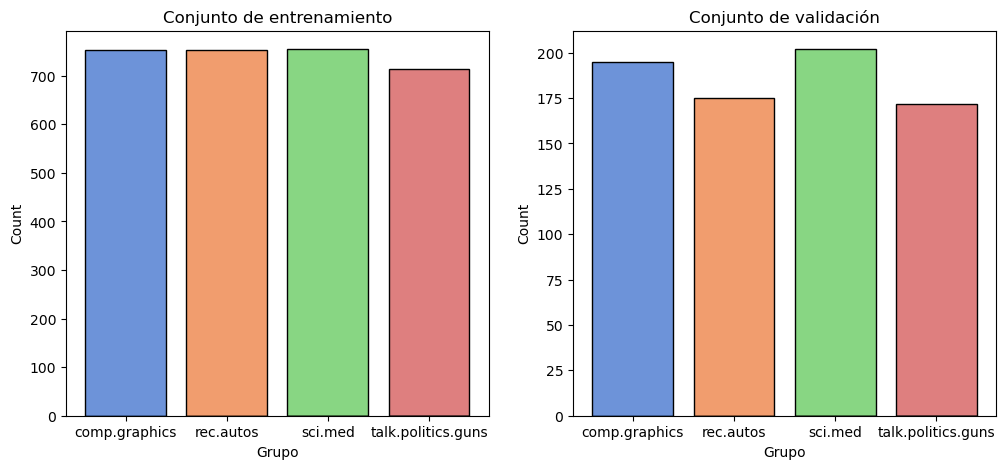

In [38]:
train_ordenado, val_ordenada = X_train.copy(deep=True), X_val.copy(deep=True)
train_ordenado['Grupo'] = pd.Categorical(train_ordenado['Grupo'], categories=orden, ordered=True)
val_ordenada['Grupo'] = pd.Categorical(val_ordenada['Grupo'], categories=orden, ordered=True)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=train_ordenado, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False, palette='muted')
plt.ylabel=('Frecuencia absoluta')
plt.title('Conjunto de entrenamiento')

plt.subplot(1,2,2)
sns.histplot(data=val_ordenada, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False, palette='muted')
plt.ylabel=('Frecuencia absoluta')
plt.title('Conjunto de validación')

In [20]:
matriz_a4, tfidf_a4 = tfidf(X_train)

matriz_a4.head()

,aaa,aaah,aalong,aamir,aanerud,aangeboden,aantalsnijpunten,aaplay,aaplayexe,aarnet,...,zugcsmilumichedu,zurich,zvi,zvljxxmimt,zx,zyda,zygon,zyxel,zzhlww,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
matriz_a4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974 entries, 0 to 2973
Columns: 24855 entries, aaa to zzz
dtypes: float64(24855)
memory usage: 564.0 MB


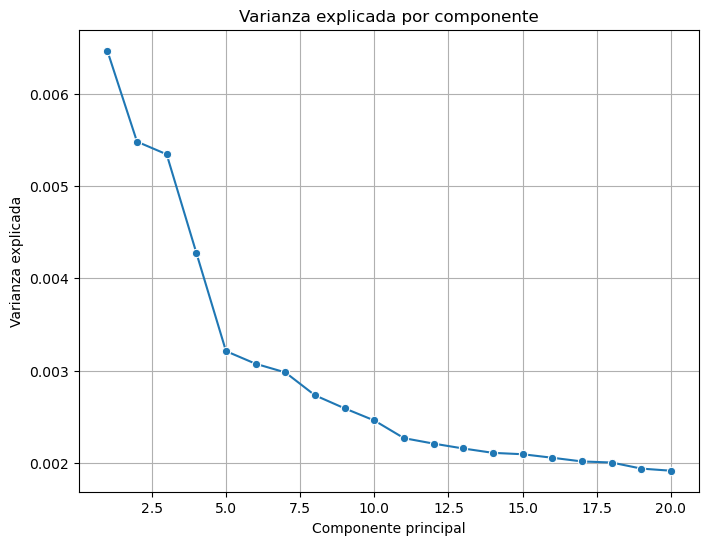

In [21]:
pca_a4, kaiser = pca(matriz_a4, graf=True)

**Método del codo:** 4 Componentes

In [22]:
n_componentes = 4
hidden_units = [4, 8]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_a4 = grid_search(matriz_a4, y_train, pca_a4, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 4, 4, 80, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.7778 - accuracy: 0.8170
79.05025631189346
Modelo con 4, 4, 80, 200
24/24 [==============================] - 0s 3ms/step - loss: 1.0656 - accuracy: 0.7954
75.3870353102684
Modelo con 4, 4, 150, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.5759 - accuracy: 0.8385
82.61583745479584
Modelo con 4, 4, 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.7534 - accuracy: 0.8304
81.06932640075684
Modelo con 4, 8, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.8385
82.51471668481827
Modelo con 4, 8, 80, 200
24/24 [==============================] - 0s 965us/step - loss: 0.8313 - accuracy: 0.8156
79.18633818626404
Modelo con 4, 8, 150, 100
24/24 [==============================] - 0s 3ms/step - loss: 0.4626 - accuracy: 0.8479
83.55728685855865
Modelo con 4, 8, 150, 200
24/24 [==============================] - 0s 2ms/step - loss:

In [23]:
dict(sorted(resultados_a4.items(), key=lambda item: item[1], reverse=True))

{(4, 8, 150, 100): 0.8355728685855865,
 (4, 4, 150, 100): 0.8261583745479584,
 (4, 8, 80, 100): 0.8251471668481827,
 (4, 8, 150, 200): 0.8126998990774155,
 (4, 4, 150, 200): 0.8106932640075684,
 (4, 8, 80, 200): 0.7918633818626404,
 (4, 4, 80, 100): 0.7905025631189346,
 (4, 4, 80, 200): 0.753870353102684}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 1ms/step


0.831989247311828

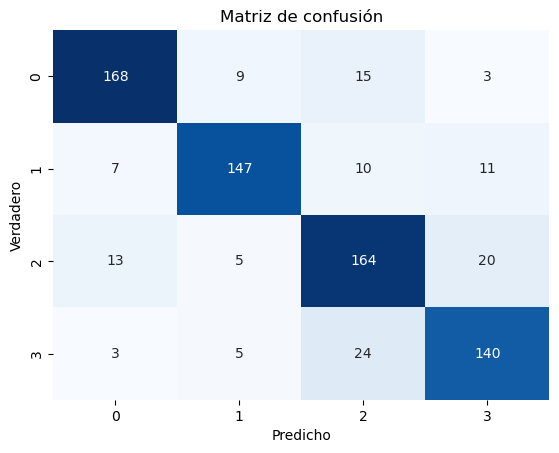

In [24]:
X_4 = pca_a4.transform(matriz_a4)[:,:4]

acc_codo = modelaje_final(X_4, y_train, X_val, y_val, tfidf_a4, pca_a4, 4, 8, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [50]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_a4 = grid_search(matriz_a4, y_train, pca_a4, n_componentes, hidden_units, epochs, batch_sizes, resultados_a4)

Modelo con 300, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.3251 - accuracy: 0.8856
88.90418857336044
Modelo con 300, [64, 10], 80, 200
24/24 [==============================] - 0s 1ms/step - loss: 0.3094 - accuracy: 0.8950
88.83712142705917
Modelo con 300, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.2981 - accuracy: 0.8950
88.8707235455513
Modelo con 300, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8950
89.0050858259201
Modelo con 300, 100, 80, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.3039 - accuracy: 0.8937
88.73617947101593
Modelo con 300, 100, 80, 200
24/24 [==============================] - 0s 1ms/step - loss: 0.3142 - accuracy: 0.8896
88.50087374448776
Modelo con 300, 100, 150, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.3068 - accuracy: 0.8964
89.0388697385788
Modelo con 300, 100, 150, 200
24/24 [=====

In [51]:
dict(sorted(resultados_a4.items(), key=lambda item: item[1], reverse=True))

{(300, (80, 20), 150, 100): 0.8937516212463379,
 (300, (80, 20), 150, 200): 0.8910607397556305,
 (300, 100, 150, 100): 0.890388697385788,
 (300, (80, 20), 80, 100): 0.8900531232357025,
 (300, (64, 10), 150, 200): 0.890050858259201,
 (300, (64, 10), 80, 100): 0.8890418857336044,
 (300, (64, 10), 150, 100): 0.888707235455513,
 (300, (64, 10), 80, 200): 0.8883712142705917,
 (300, 100, 80, 100): 0.8873617947101593,
 (300, (80, 20), 80, 200): 0.8856821358203888,
 (300, 100, 80, 200): 0.8850087374448776,
 (300, 100, 150, 200): 0.8833272755146027,
 (4, 10, 150, 100): 0.8359102457761765,
 (4, 5, 150, 100): 0.8264948576688766,
 (4, 10, 150, 200): 0.8264930546283722,
 (4, 10, 80, 100): 0.8221220672130585,
 (4, 5, 150, 200): 0.8019535392522812,
 (4, 10, 80, 200): 0.7958974540233612,
 (4, 5, 80, 200): 0.7895198315382004,
 (4, 5, 80, 100): 0.781754270195961}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step


0.8924731182795699

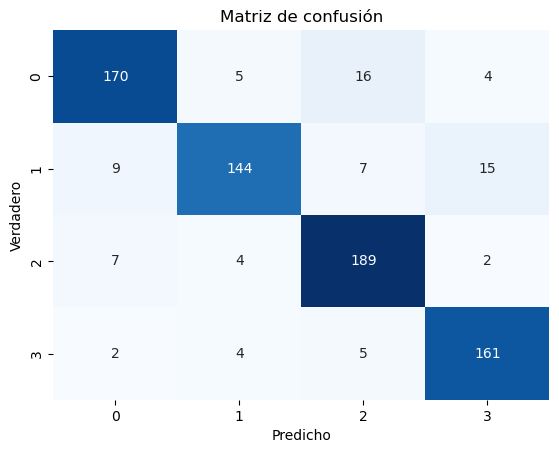

In [25]:
X_300 = pca_a4.transform(matriz_a4)[:, :300]

acc_300 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_a4, pca_a4, 300, [80,20], 150, 100, graf=True)

acc_300

### Estandarizado

Modelo con 2776, [64, 10], 80, 100
24/24 [==============================] - 0s 1ms/step - loss: 1.6992 - accuracy: 0.4415
41.897450387477875
Modelo con 2776, [64, 10], 80, 200
24/24 [==============================] - 0s 1ms/step - loss: 1.7540 - accuracy: 0.4886
43.14027652144432
Modelo con 2776, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.9014 - accuracy: 0.4415
40.95568582415581
Modelo con 2776, [64, 10], 150, 200
24/24 [==============================] - 0s 1ms/step - loss: 1.8045 - accuracy: 0.4455
44.08045932650566
Modelo con 2776, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.8035 - accuracy: 0.5437
53.89993041753769
Modelo con 2776, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.8571 - accuracy: 0.5316
51.34444683790207
Modelo con 2776, 100, 150, 100
24/24 [==============================] - 0s 1ms/step - loss: 1.5416 - accuracy: 0.5734
55.380550026893616
Modelo con 2776, 100, 150, 200

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 4ms/step
Modelo con 300, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.7844 - accuracy: 0.8668
86.38181239366531
Modelo con 300, [64, 10], 80, 200
24/24 [==============================] - 0s 1ms/step - loss: 0.5073 - accuracy: 0.8681
86.58369779586792
Modelo con 300, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5036 - accuracy: 0.8600
86.28091514110565
Modelo con 300, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.5080 - accuracy: 0.8641
86.61738932132721
Modelo con 300, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5853 - accuracy: 0.8708
87.92850524187088
Modelo con 300, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.5306 - accuracy: 0.8775
87.72711902856827
Modelo con 300, 100, 150, 100
24/24 [==============================] - 0s 3ms/step - loss: 0.5465 - accuracy: 0.8641
87.0

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step


{'Kaiser': 0.7688172043010753, '300': 0.4717741935483871}

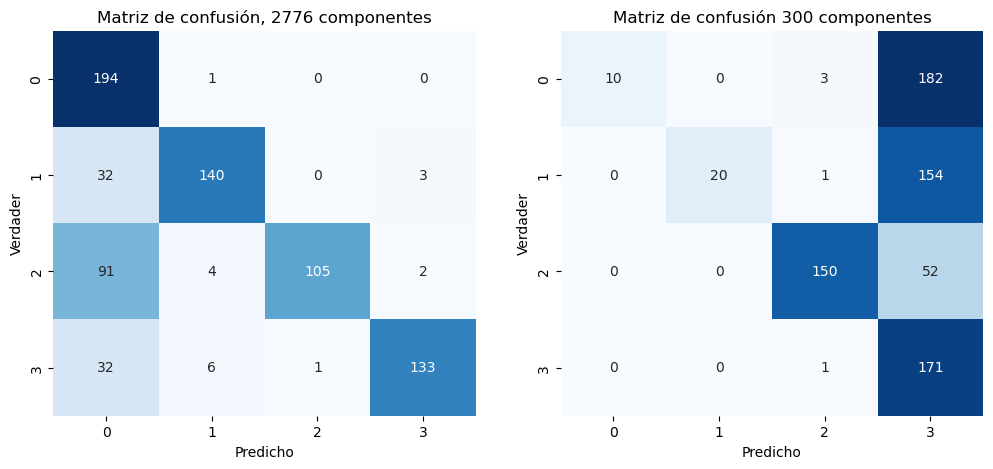

In [26]:
proceso_estandar(matriz_a4, y_train, X_val, y_val, tfidf_a4)

## Bloque B1: comp

In [39]:
ng_b1 = ng_20[ng_20['Target'].isin([1, 2, 3, 4, 5])]

ng_b1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4758 entries, 1 to 18264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  4758 non-null   int64 
 1   Grupo         4758 non-null   object
 2   Documento     4758 non-null   object
 3   Target        4758 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 185.9+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

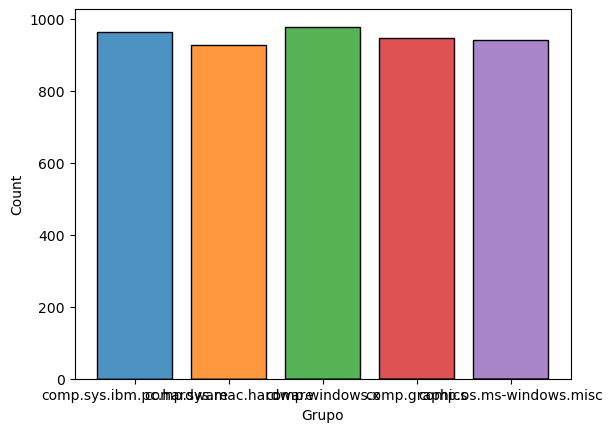

In [55]:
sns.histplot(data=ng_b1, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [56]:
set(ng_b1['Target'])

{1, 2, 3, 4, 5}

In [40]:
y_encoded = [one_hot_encoding(target-1, 5) for target in ng_b1.iloc[:,3]]

In [41]:
X, y = ng_b1.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [42]:
len(X_train), len(X_val)

(3806, 952)

Text(0.5, 1.0, 'X_val')

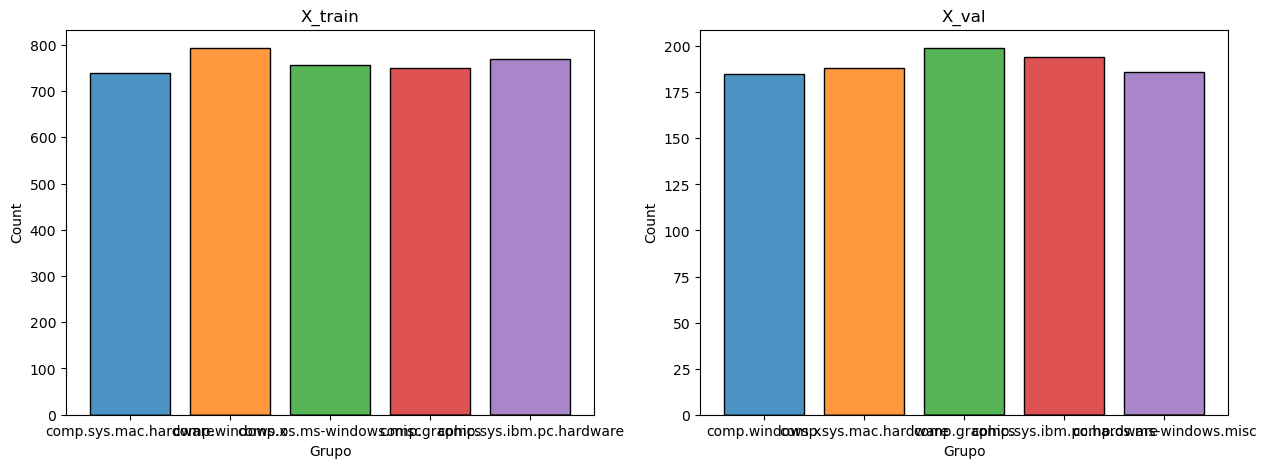

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [53]:
matriz_b1, tfidf_b1 = tfidf(X_train)

matriz_b1.head()

,aa,aaa,aaaaaaa,aaahhhh,aaareadme,aaawwte,aabxhaa,aadnsi,aafcxtex,aangeboden,...,zyyuhmmkp,zyzj,zzcgsfjsfog,zzcvtuza,zzd,zzip,zznattpupbszfy,zzqjjf,zzt,zzu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
matriz_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3806 entries, 0 to 3805
Columns: 38584 entries, aa to zzu
dtypes: float64(38584)
memory usage: 1.1 GB


In [57]:
pca_b1, kaiser = pca(matriz_b1)

**Método del codo:** 6 Componentes

In [70]:
n_componentes = 4
hidden_units = [5, 10]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b1 = grid_search(matriz_b1, y_train, pca_b1, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 4, 5, 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 1.2167 - accuracy: 0.5342
51.86595991253853
Modelo con 4, 5, 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 1.3286 - accuracy: 0.4679
47.63475954532623
Modelo con 4, 5, 150, 100
30/30 [==============================] - 0s 1ms/step - loss: 1.1083 - accuracy: 0.5478
54.44061905145645
Modelo con 4, 5, 150, 200
30/30 [==============================] - 0s 1ms/step - loss: 1.1729 - accuracy: 0.5415
53.86211574077606
Modelo con 4, 10, 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 1.1396 - accuracy: 0.5510
54.25687879323959
Modelo con 4, 10, 80, 200
30/30 [==============================] - 0s 1ms/step - loss: 1.1804 - accuracy: 0.5521
54.23048138618469
Modelo con 4, 10, 150, 100
30/30 [==============================] - 0s 1ms/step - loss: 1.0984 - accuracy: 0.5405
54.755665361881256
Modelo con 4, 10, 150, 200
30/30 [==============================] - 0s 1ms/step - l

In [71]:
dict(sorted(resultados_b1.items(), key=lambda item: item[1], reverse=True))

{(4, 10, 150, 100): 0.5475566536188126,
 (4, 5, 150, 100): 0.5444061905145645,
 (4, 10, 80, 100): 0.5425687879323959,
 (4, 10, 80, 200): 0.5423048138618469,
 (4, 10, 150, 200): 0.540727511048317,
 (4, 5, 150, 200): 0.5386211574077606,
 (4, 5, 80, 100): 0.5186595991253853,
 (4, 5, 80, 200): 0.47634759545326233}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


30/30 [==============================] - 0s 1ms/step


TypeError: 'str' object is not callable

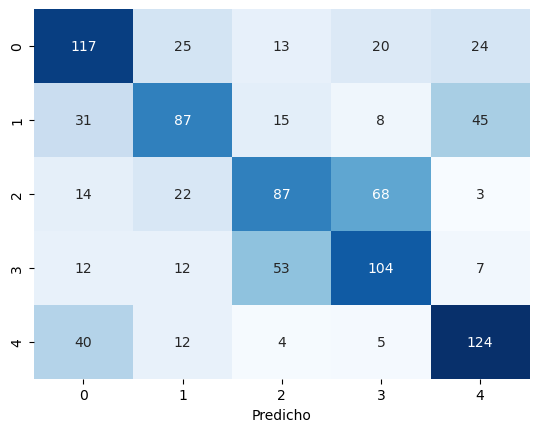

In [58]:
X_4 = pca_b1.transform(matriz_b1)[:,:4]

acc_codo = modelaje_final(X_4, y_train, X_val, y_val, tfidf_b1, pca_b1, 4, 10, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [74]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b1 = grid_search(matriz_b1, y_train, pca_b1, n_componentes, hidden_units, epochs, batch_sizes, resultados_b1)

Modelo con 300, [64, 10], 80, 100
30/30 [==============================] - 0s 1ms/step - loss: 0.7477 - accuracy: 0.7203
72.3591759800911
Modelo con 300, [64, 10], 80, 200
30/30 [==============================] - 0s 1ms/step - loss: 0.7426 - accuracy: 0.7203
71.07232809066772
Modelo con 300, [64, 10], 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.7339 - accuracy: 0.7224
72.30715155601501
Modelo con 300, [64, 10], 150, 200
30/30 [==============================] - 0s 2ms/step - loss: 0.7226 - accuracy: 0.7256
71.70258015394211
Modelo con 300, 100, 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.7268 - accuracy: 0.7298
72.4644660949707
Modelo con 300, 100, 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 0.7341 - accuracy: 0.7298
71.88659757375717
Modelo con 300, 100, 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.7174 - accuracy: 0.7329
72.41213917732239
Modelo con 300, 100, 150, 200
30/30 [====

In [75]:
dict(sorted(resultados_b1.items(), key=lambda item: item[1], reverse=True))

{(300, (80, 20), 80, 100): 0.7296385914087296,
 (300, (80, 20), 80, 200): 0.7264840006828308,
 (300, 100, 80, 100): 0.724644660949707,
 (300, 100, 150, 100): 0.7241213917732239,
 (300, (64, 10), 80, 100): 0.723591759800911,
 (300, (64, 10), 150, 100): 0.7230715155601501,
 (300, (80, 20), 150, 200): 0.7225391417741776,
 (300, (80, 20), 150, 100): 0.7220166772603989,
 (300, 100, 80, 200): 0.7188659757375717,
 (300, (64, 10), 150, 200): 0.7170258015394211,
 (300, 100, 150, 200): 0.7167631983757019,
 (300, (64, 10), 80, 200): 0.7107232809066772,
 (4, 10, 150, 100): 0.5475566536188126,
 (4, 5, 150, 100): 0.5444061905145645,
 (4, 10, 80, 100): 0.5425687879323959,
 (4, 10, 80, 200): 0.5423048138618469,
 (4, 10, 150, 200): 0.540727511048317,
 (4, 5, 150, 200): 0.5386211574077606,
 (4, 5, 80, 100): 0.5186595991253853,
 (4, 5, 80, 200): 0.47634759545326233}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


30/30 [==============================] - 0s 2ms/step


0.7195378151260504

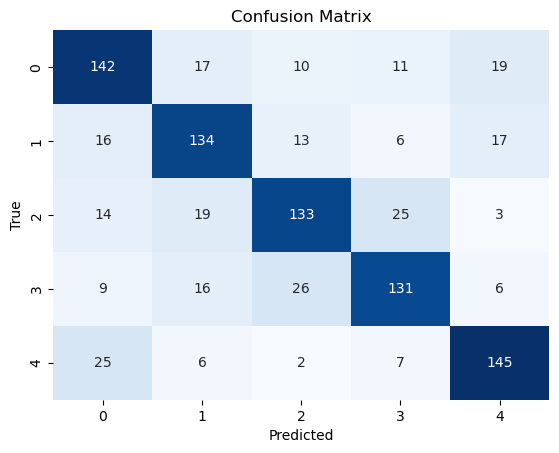

In [76]:
X_300 = pca_b1.transform(matriz_b1)[:,:300]

acc_300 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_b1, pca_b1, 300, [82, 20], 80, 100, graf=True)

acc_300

### Estandarizado

Modelo con 3210, [64, 10], 80, 100
30/30 [==============================] - 0s 3ms/step - loss: 2.5466 - accuracy: 0.3596
34.681566059589386
Modelo con 3210, [64, 10], 80, 200
30/30 [==============================] - 0s 3ms/step - loss: 1.8553 - accuracy: 0.4111
38.70270848274231
Modelo con 3210, [64, 10], 150, 100
30/30 [==============================] - 0s 3ms/step - loss: 1.8074 - accuracy: 0.3512
34.73488762974739
Modelo con 3210, [64, 10], 150, 200
30/30 [==============================] - 0s 2ms/step - loss: 2.4104 - accuracy: 0.3722
36.573150753974915
Modelo con 3210, 100, 80, 100
30/30 [==============================] - 0s 3ms/step - loss: 2.1192 - accuracy: 0.4416
44.2985437810421
Modelo con 3210, 100, 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 2.7191 - accuracy: 0.4385
42.98504814505577
Modelo con 3210, 100, 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 2.7009 - accuracy: 0.4490
44.11463662981987
Modelo con 3210, 100, 150, 200


D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


30/30 [==============================] - 0s 2ms/step
Modelo con 300, [64, 10], 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 1.8172 - accuracy: 0.6236
60.53626090288162
Modelo con 300, [64, 10], 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 1.1893 - accuracy: 0.6688
62.454548478126526
Modelo con 300, [64, 10], 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 1.4253 - accuracy: 0.6540
60.93149483203888
Modelo con 300, [64, 10], 150, 200
30/30 [==============================] - 0s 2ms/step - loss: 1.1514 - accuracy: 0.6709
63.190364837646484
Modelo con 300, 100, 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 2.1756 - accuracy: 0.6667
64.60873782634735
Modelo con 300, 100, 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 1.6544 - accuracy: 0.6740
65.76480716466904
Modelo con 300, 100, 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 1.7896 - accuracy: 0.6751
65

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


30/30 [==============================] - 0s 1ms/step


{'Kaiser': 0.6680672268907563, '300': 0.46218487394957986}

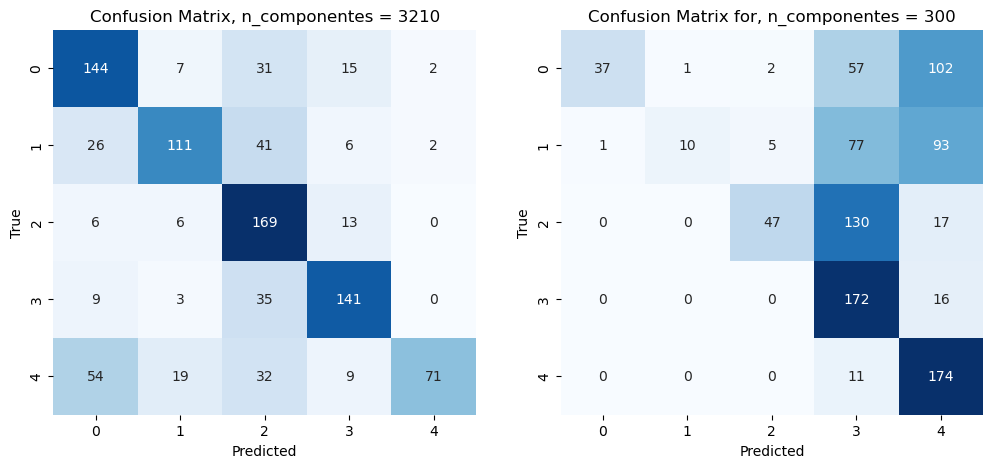

In [77]:
proceso_estandar(matriz_b1, y_train, X_val, y_val, tfidf_b1)

## Bloque B2: rec

In [12]:
ng_b2 = ng_20[ng_20['Target'].isin([7, 8, 9, 10])]
ng_b2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3813 entries, 0 to 18265
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  3813 non-null   int64 
 1   Grupo         3813 non-null   object
 2   Documento     3813 non-null   object
 3   Target        3813 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 148.9+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

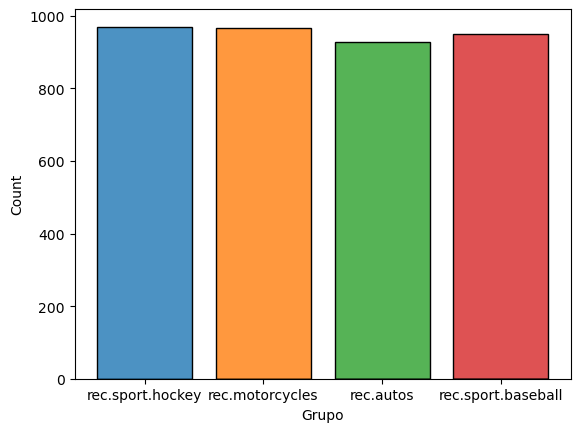

In [79]:
sns.histplot(data=ng_b2, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [80]:
y_encoded = [one_hot_encoding(target-7, 4) for target in ng_b2.iloc[:,3]]

In [81]:
X, y = ng_b2.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [82]:
len(X_train), len(X_val)

(3050, 763)

Text(0.5, 1.0, 'X_val')

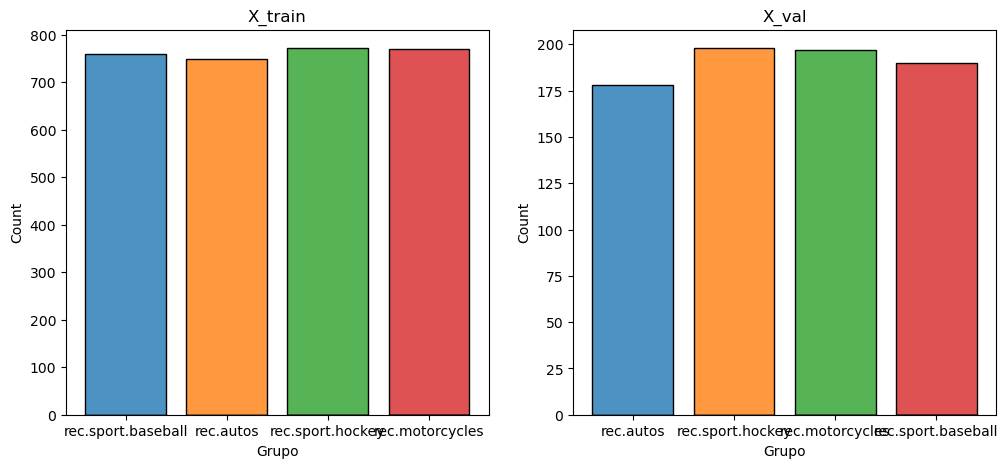

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [84]:
matriz_b2, tfidf_b2 = tfidf(X_train)

matriz_b2.head()

,aa,aaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaarrrrgh,aaaggghhh,aadams,aamir,aargh,aarhus,aaron,...,zoom,zounds,zubov,zuki,zupancic,zupcic,zurich,zx,zxa,zzzzzzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
matriz_b2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Columns: 18624 entries, aa to zzzzzzt
dtypes: float64(18624)
memory usage: 433.4 MB


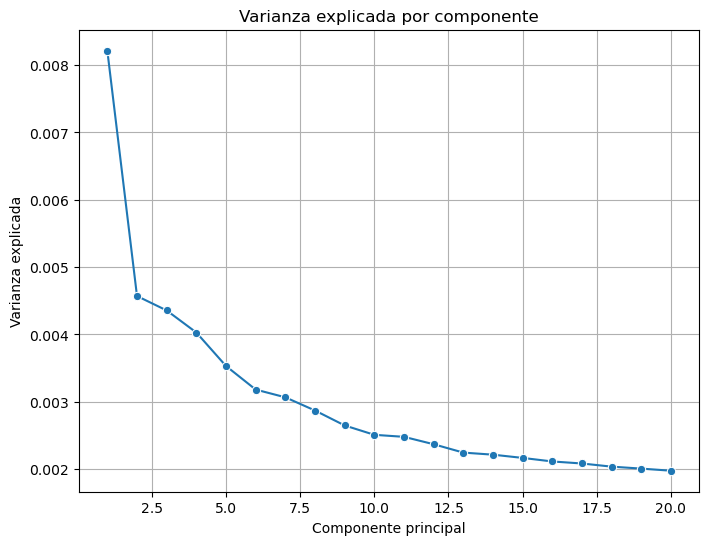

In [86]:
pca_b2, kaiser = pca(matriz_b2, graf=True)

**Método del codo:** 5 Componentes

In [93]:
n_componentes = 5
hidden_units = [5, 10]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b2 = grid_search(matriz_b2, y_train, pca_b2, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 5, 5, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.7589 - accuracy: 0.7795
78.29507291316986
Modelo con 5, 5, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.1256 - accuracy: 0.7533
70.56050151586533
Modelo con 5, 5, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5735 - accuracy: 0.8045
78.88540923595428
Modelo con 5, 5, 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.7992
79.21323478221893
Modelo con 5, 10, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5742 - accuracy: 0.8084
78.91838997602463
Modelo con 5, 10, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.7775 - accuracy: 0.7822
77.63963639736176
Modelo con 5, 10, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5006 - accuracy: 0.8018
79.50808107852936
Modelo con 5, 10, 150, 200
24/24 [==============================] - 0s 2ms/step - lo

In [94]:
dict(sorted(resultados_b2.items(), key=lambda item: item[1], reverse=True))

{(5, 10, 150, 100): 0.7950808107852936,
 (5, 5, 150, 200): 0.7921323478221893,
 (5, 10, 150, 200): 0.7898349016904831,
 (5, 10, 80, 100): 0.7891838997602463,
 (5, 5, 150, 100): 0.7888540923595428,
 (5, 5, 80, 100): 0.7829507291316986,
 (5, 10, 80, 200): 0.7763963639736176,
 (5, 5, 80, 200): 0.7056050151586533}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 1ms/step


0.8007863695937091

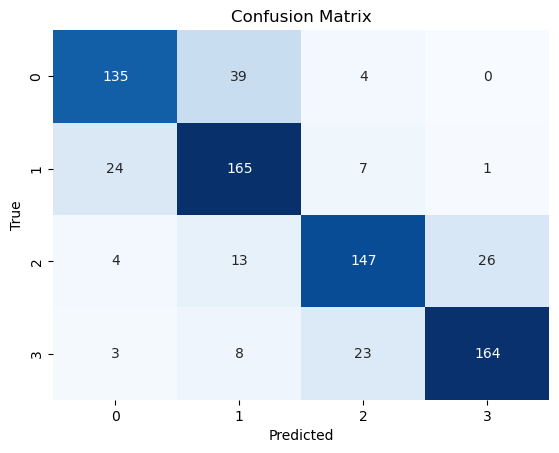

In [95]:
X_5 = pca_b2.transform(matriz_b2)[:,:5]

acc_codo = modelaje_final(X_5, y_train, X_val, y_val, tfidf_b2, pca_b2, 5, 10, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [89]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b2 = grid_search(matriz_b2, y_train, pca_b2, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 300, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.3911 - accuracy: 0.8465
86.13103479146957
Modelo con 300, [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8478
85.63942313194275
Modelo con 300, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8451
85.6721892952919
Modelo con 300, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4147 - accuracy: 0.8465
85.50862073898315
Modelo con 300, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4081 - accuracy: 0.8543
86.29512041807175
Modelo con 300, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.8465
85.7706144452095
Modelo con 300, 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8517
86.00010126829147
Modelo con 300, 100, 150, 200
24/24 [====

In [90]:
dict(sorted(resultados_b2.items(), key=lambda item: item[1], reverse=True))

{(300, (80, 20), 80, 100): 0.8652447611093521,
 (300, 100, 80, 100): 0.8629512041807175,
 (300, (80, 20), 150, 100): 0.8622980266809464,
 (300, (64, 10), 80, 100): 0.8613103479146957,
 (300, 100, 150, 100): 0.8600010126829147,
 (300, (80, 20), 150, 200): 0.8600010126829147,
 (300, (80, 20), 80, 200): 0.8599992841482162,
 (300, 100, 80, 200): 0.857706144452095,
 (300, (64, 10), 150, 100): 0.856721892952919,
 (300, (64, 10), 80, 200): 0.8563942313194275,
 (300, 100, 150, 200): 0.8560682982206345,
 (300, (64, 10), 150, 200): 0.8550862073898315}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step


0.8623853211009175

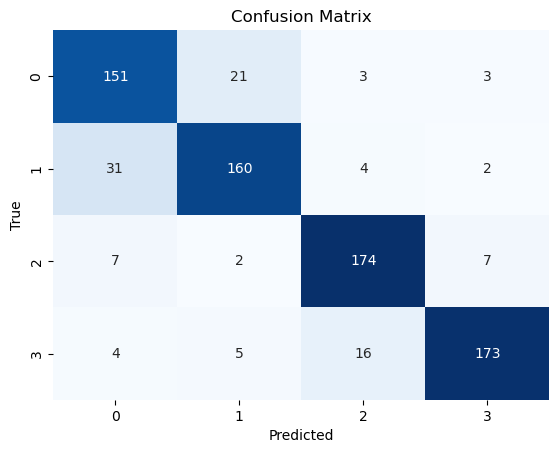

In [91]:
X_300 = pca_b2.transform(matriz_b2)[:,:300]

acc_300 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_b2, pca_b2, 300, [80,20], 80, 100, graf=True)

acc_300

### Estandarizado

Modelo con 2728, [64, 10], 80, 100
24/24 [==============================] - 0s 3ms/step - loss: 1.5970 - accuracy: 0.3871
43.474310636520386
Modelo con 2728, [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.8339 - accuracy: 0.3780
41.54076501727104
Modelo con 2728, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.4005 - accuracy: 0.4409
40.22963345050812
Modelo con 2728, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.7822 - accuracy: 0.4357
40.722059458494186
Modelo con 2728, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.9246 - accuracy: 0.4934
51.081473380327225
Modelo con 2728, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.9788 - accuracy: 0.4843
48.62200543284416
Modelo con 2728, 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.7673 - accuracy: 0.5131
52.32673063874245
Modelo con 2728, 100, 150, 20

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step
Modelo con 300, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.7664 - accuracy: 0.8071
79.96718138456345
Modelo con 300, [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.6609 - accuracy: 0.7966
79.86875921487808
Modelo con 300, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.8084
79.93510514497757
Modelo con 300, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.8374 - accuracy: 0.7808
79.27786409854889
Modelo con 300, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.8136
81.54142796993256
Modelo con 300, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.9053 - accuracy: 0.8123
81.60622715950012
Modelo con 300, 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.7176 - accuracy: 0.8150
81.6

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 1ms/step


{'Kaiser': 0.6264744429882044, '300': 0.5058977719528178}

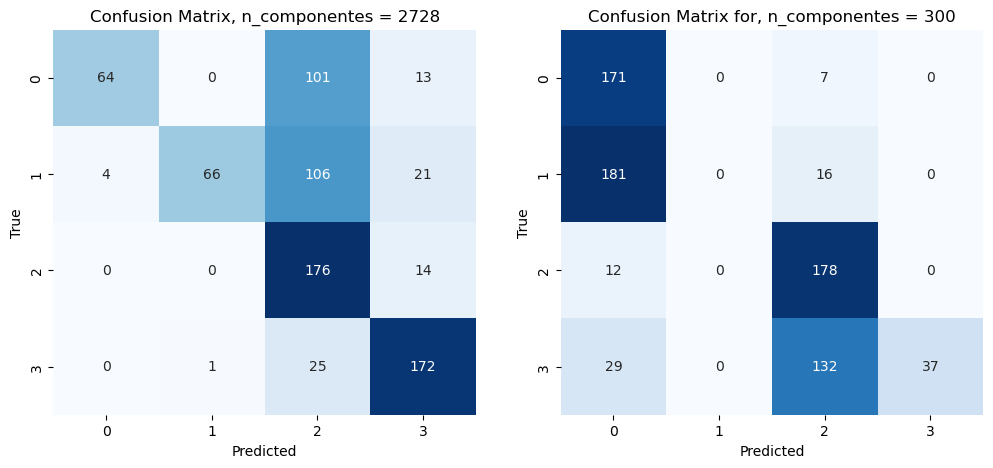

In [87]:
proceso_estandar(matriz_b2, y_train, X_val, y_val, tfidf_b2)

## Bloque B3: sci

In [13]:
ng_b3 = ng_20[ng_20['Target'].isin([11, 12, 13, 14])]
ng_b3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 5 to 18262
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  3828 non-null   int64 
 1   Grupo         3828 non-null   object
 2   Documento     3828 non-null   object
 3   Target        3828 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 149.5+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

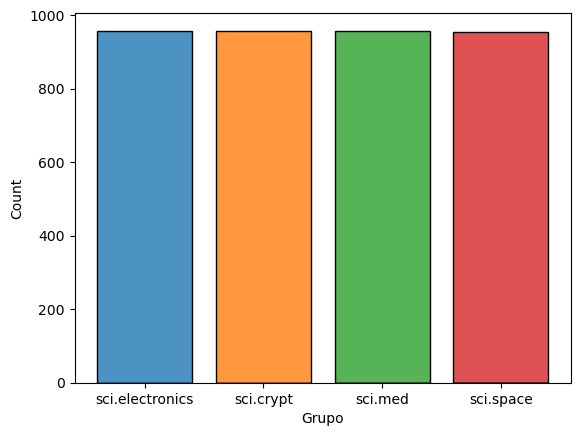

In [97]:
sns.histplot(data=ng_b3, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [98]:
y_encoded = [one_hot_encoding(target-11, 4) for target in ng_b3.iloc[:,3]]

In [99]:
X, y = ng_b3.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [100]:
len(X_train), len(X_val)

(3062, 766)

Text(0.5, 1.0, 'X_val')

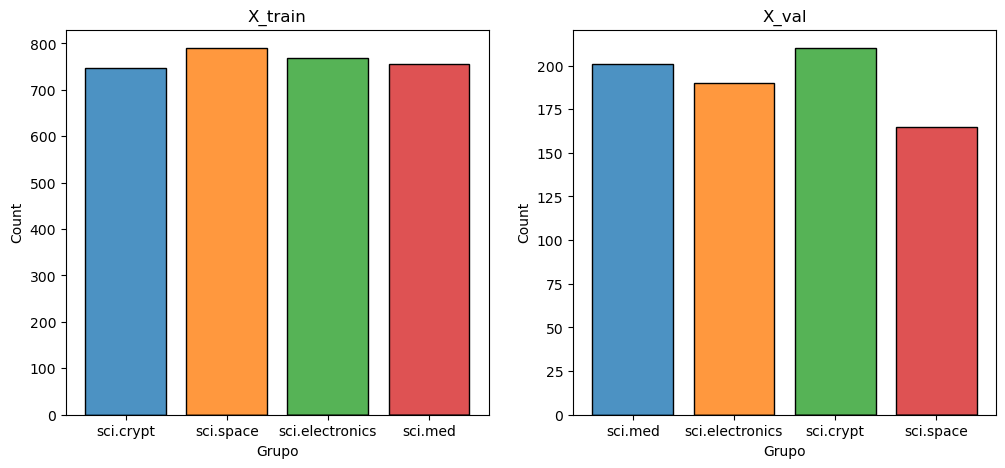

In [101]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [102]:
matriz_b3, tfidf_b3 = tfidf(X_train)

matriz_b3.head()

,aaaaa,aaahh,aachende,aacs,aaer,aagain,aalong,aalternate,aanerud,aanxiety,...,zonker,zoology,ztimer,zubkoff,zubrin,zulu,zundel,zvezdny,zygon,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
matriz_b3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Columns: 24918 entries, aaaaa to zyxel
dtypes: float64(24918)
memory usage: 582.1 MB


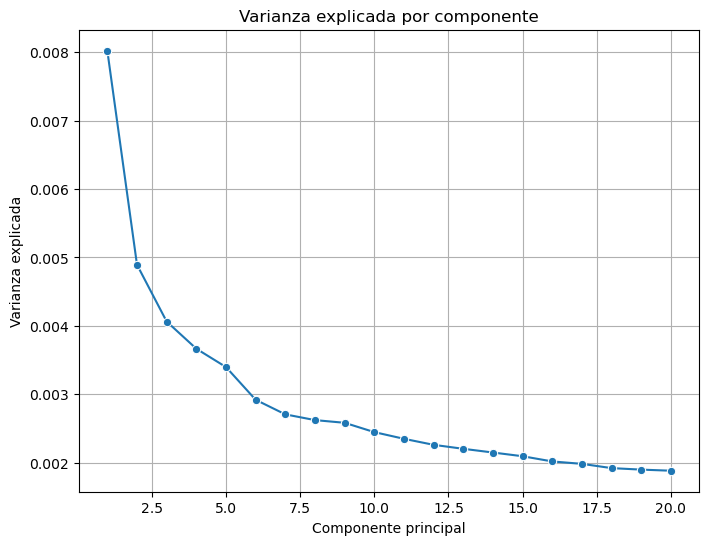

In [104]:
pca_b3, kaiser = pca(matriz_b3, graf=True)

**Método del codo:** 5 Componentes

In [105]:
n_componentes = 5
hidden_units = [5, 10]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b3 = grid_search(matriz_b3, y_train, pca_b3, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 5, 5, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.7882
78.1515046954155
Modelo con 5, 5, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.7216
73.3160987496376
Modelo con 5, 5, 150, 100
24/24 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.7516
78.21622490882874
Modelo con 5, 5, 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.6751 - accuracy: 0.7882
77.59603410959244
Modelo con 5, 10, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.6073 - accuracy: 0.7922
79.4900506734848
Modelo con 5, 10, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.7805 - accuracy: 0.7778
77.88989692926407
Modelo con 5, 10, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.5099 - accuracy: 0.8052
80.40491342544556
Modelo con 5, 10, 150, 200
24/24 [==============================] - 0s 2ms/step - loss:

In [106]:
dict(sorted(resultados_b3.items(), key=lambda item: item[1], reverse=True))

{(5, 10, 150, 100): 0.8040491342544556,
 (5, 10, 150, 200): 0.7952298820018768,
 (5, 10, 80, 100): 0.794900506734848,
 (5, 5, 150, 100): 0.7821622490882874,
 (5, 5, 80, 100): 0.781515046954155,
 (5, 10, 80, 200): 0.7788989692926407,
 (5, 5, 150, 200): 0.7759603410959244,
 (5, 5, 80, 200): 0.733160987496376}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step


0.8263707571801566

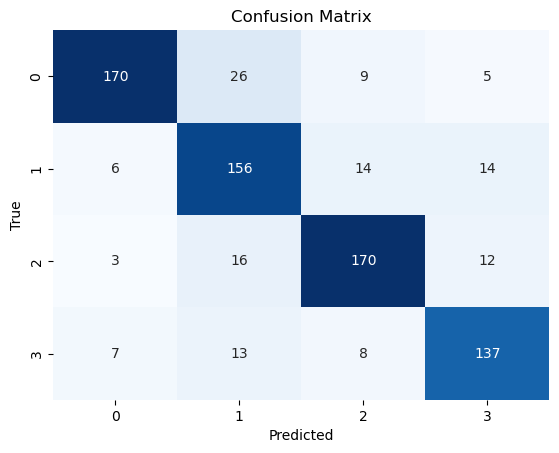

In [108]:
X_5 = pca_b3.transform(matriz_b3)[:,:5]

acc_codo = modelaje_final(X_5, y_train, X_val, y_val, tfidf_b3, pca_b3, 5, 10, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [109]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b3 = grid_search(matriz_b3, y_train, pca_b3, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 300, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.8497
86.0549658536911
Modelo con 300, [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.8458
85.92446148395538
Modelo con 300, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.8444
86.25104427337646
Modelo con 300, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.8497
85.76131910085678
Modelo con 300, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8471
86.25100255012512
Modelo con 300, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.8458
85.72846800088882
Modelo con 300, 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.8458
85.95714122056961
Modelo con 300, 100, 150, 200
24/24 [===

In [110]:
dict(sorted(resultados_b3.items(), key=lambda item: item[1], reverse=True))

{(300, (80, 20), 80, 100): 0.8647980242967606,
 (300, (64, 10), 150, 100): 0.8625104427337646,
 (300, 100, 80, 100): 0.8625100255012512,
 (300, (64, 10), 80, 100): 0.860549658536911,
 (300, (80, 20), 150, 100): 0.8602241575717926,
 (300, (80, 20), 80, 200): 0.8598960787057877,
 (300, 100, 150, 100): 0.8595714122056961,
 (300, (64, 10), 80, 200): 0.8592446148395538,
 (300, 100, 150, 200): 0.8592433333396912,
 (300, (64, 10), 150, 200): 0.8576131910085678,
 (300, (80, 20), 150, 200): 0.8576127588748932,
 (300, 100, 80, 200): 0.8572846800088882}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 1ms/step


0.8838120104438643

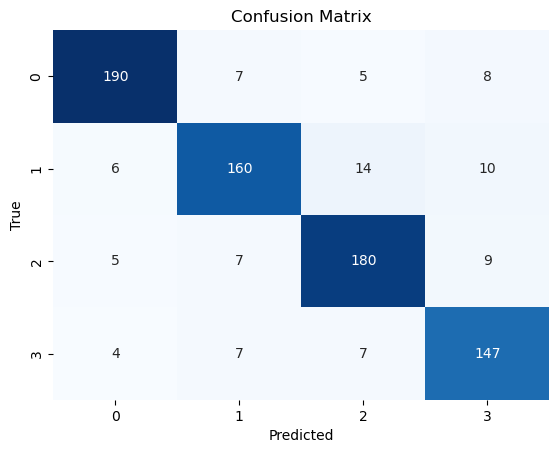

In [111]:
X_300 = pca_b3.transform(matriz_b3)[:,:300]

acc_b3 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_b3, pca_b3, 300, [80,20], 80, 100, graf=True)

acc_b3

### Estandarizado

Modelo con 2886, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.5445 - accuracy: 0.4065
40.65982401371002
Modelo con 2886, [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.4742 - accuracy: 0.4314
39.71531167626381
Modelo con 2886, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.4856 - accuracy: 0.4209
39.55084532499313
Modelo con 2886, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.6331 - accuracy: 0.3608
39.9723544716835
Modelo con 2886, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 2.1486 - accuracy: 0.4471
49.14955943822861
Modelo con 2886, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 1.8051 - accuracy: 0.4993
48.563285917043686
Modelo con 2886, 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 1.7656 - accuracy: 0.5124
50.35969242453575
Modelo con 2886, 100, 150, 200
2

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step
Modelo con 300, [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.6381 - accuracy: 0.8484
83.6059495806694
Modelo con 300, [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.7640 - accuracy: 0.8340
83.213110268116
Modelo con 300, [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.8549
83.8988721370697
Modelo con 300, [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.8090 - accuracy: 0.8353
83.05030912160873
Modelo con 300, 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.9983 - accuracy: 0.8405
84.03010368347168
Modelo con 300, 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.8881 - accuracy: 0.8314
83.93180966377258
Modelo con 300, 100, 150, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.7366 - accuracy: 0.8379
83.73598

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


24/24 [==============================] - 0s 2ms/step


{'Kaiser': 0.5234986945169713, '300': 0.4765013054830287}

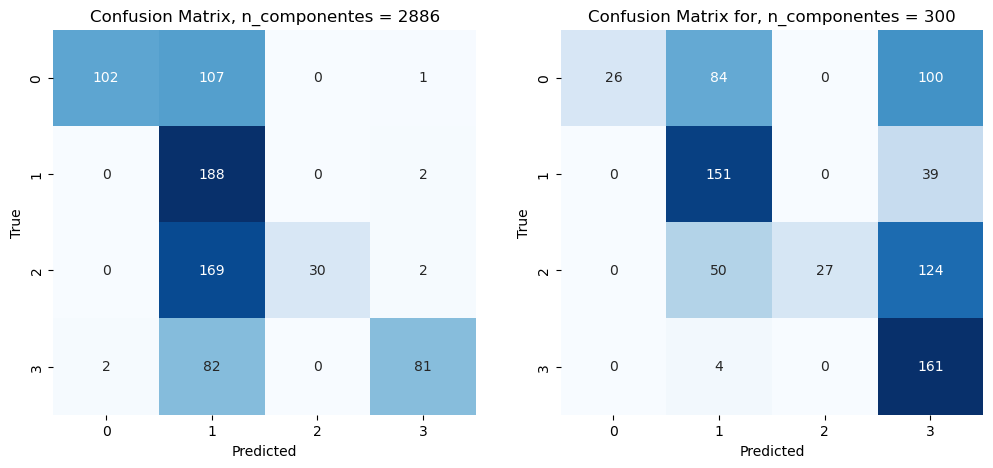

In [112]:
proceso_estandar(matriz_b3, y_train, X_val, y_val, tfidf_b3)

## Bloque B4: talk

In [113]:
ng_b4 = ng_20[ng_20['Target'].isin([16, 17, 18, 19])]
ng_b4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3158 entries, 2 to 18258
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  3158 non-null   int64 
 1   Grupo         3158 non-null   object
 2   Documento     3158 non-null   object
 3   Target        3158 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 123.4+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

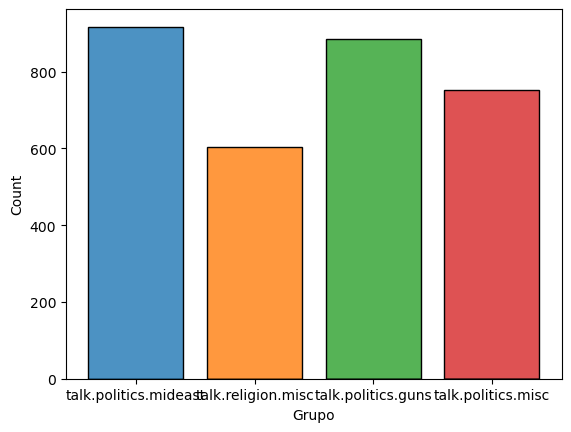

In [114]:
sns.histplot(data=ng_b4, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [115]:
y_encoded = [one_hot_encoding(target-16, 4) for target in ng_b4.iloc[:,3]]

In [116]:
X, y = ng_b4.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [117]:
len(X_train), len(X_val)

(2526, 632)

Text(0.5, 1.0, 'X_val')

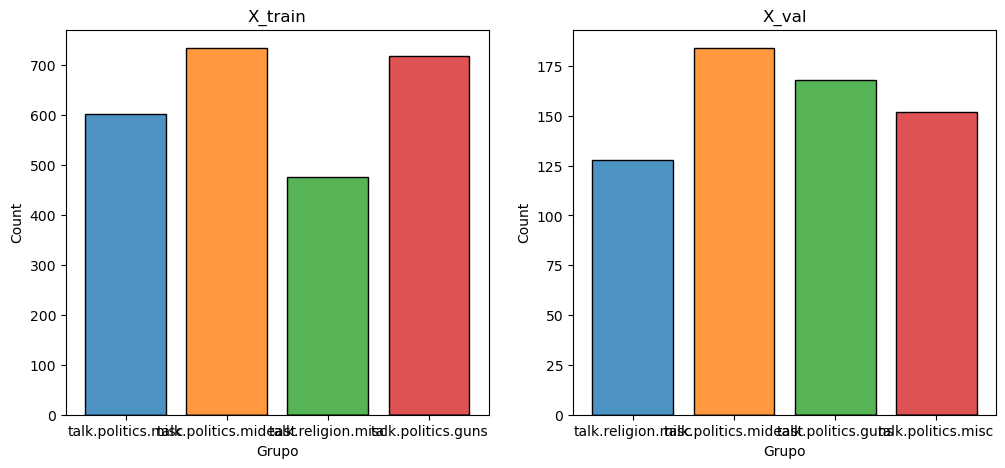

In [118]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [119]:
matriz_b4, tfidf_b4 = tfidf(X_train)

matriz_b4.head()

,aaa,aaaaaaaaaaaa,aaaall,aand,aap,aaron,aarp,aarskog,aaske,aayauwobjxerkyidcgyhmb,...,zuhair,zuma,zumrut,zumwalt,zuni,zur,zvai,zvljxxmimt,zwischen,zzhlww
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
matriz_b4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Columns: 23920 entries, aaa to zzhlww
dtypes: float64(23920)
memory usage: 461.0 MB


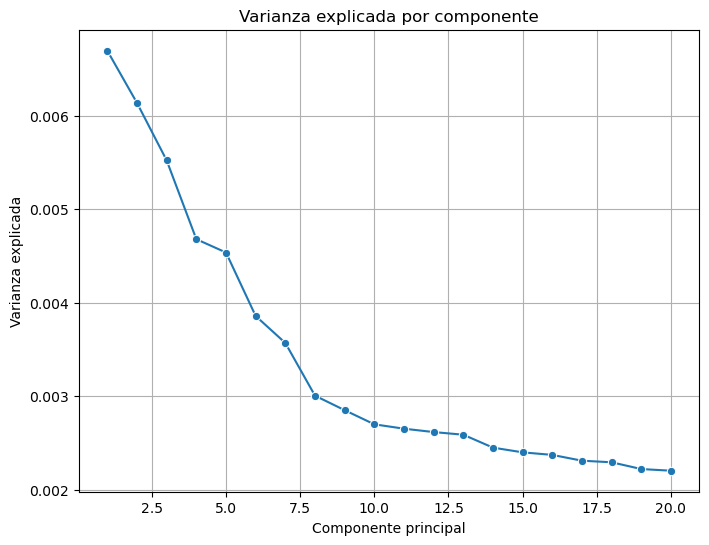

In [121]:
pca_b4, kaiser = pca(matriz_b4, graf=True)

**Método del codo:** 7 Componentes

In [122]:
n_componentes = 7
hidden_units = [6, 12]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b4 = grid_search(matriz_b4, y_train, pca_b4, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 7, 6, 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.8486 - accuracy: 0.7021
70.42662650346756
Modelo con 7, 6, 80, 200
20/20 [==============================] - 0s 1ms/step - loss: 0.9971 - accuracy: 0.6735
66.54665917158127
Modelo con 7, 6, 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.7599 - accuracy: 0.7132
71.4568629860878
Modelo con 7, 6, 150, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.8641 - accuracy: 0.7052
70.5463632941246
Modelo con 7, 12, 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.7875 - accuracy: 0.7179
71.65458351373672
Modelo con 7, 12, 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.8832 - accuracy: 0.7084
70.66459506750107
Modelo con 7, 12, 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.7477 - accuracy: 0.7290
71.89280539751053
Modelo con 7, 12, 150, 200
20/20 [==============================] - 0s 2ms/step - loss

In [123]:
dict(sorted(resultados_b4.items(), key=lambda item: item[1], reverse=True))

{(7, 12, 150, 100): 0.7189280539751053,
 (7, 12, 80, 100): 0.7165458351373672,
 (7, 6, 150, 100): 0.714568629860878,
 (7, 12, 150, 200): 0.7125844955444336,
 (7, 12, 80, 200): 0.7066459506750107,
 (7, 6, 150, 200): 0.705463632941246,
 (7, 6, 80, 100): 0.7042662650346756,
 (7, 6, 80, 200): 0.6654665917158127}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


20/20 [==============================] - 0s 2ms/step


0.7626582278481012

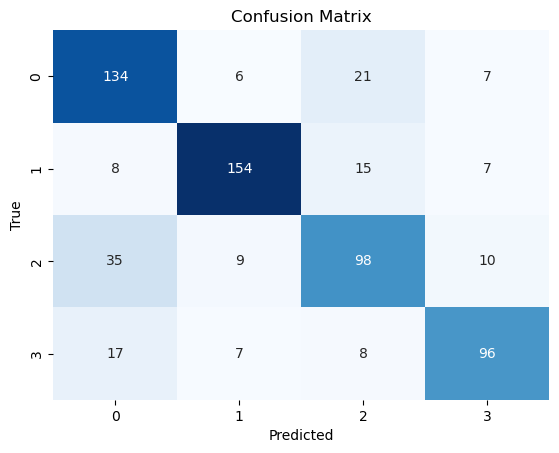

In [124]:
X_7 = pca_b4.transform(matriz_b4)[:,:7]

acc_codo = modelaje_final(X_7, y_train, X_val, y_val, tfidf_b4, pca_b4, 7, 12, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [125]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_b4 = grid_search(matriz_b4, y_train, pca_b4, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 300, [64, 10], 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6553 - accuracy: 0.7686
76.01017653942108
Modelo con 300, [64, 10], 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.6681 - accuracy: 0.7702
75.97074508666992
Modelo con 300, [64, 10], 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6680 - accuracy: 0.7607
76.04960650205612
Modelo con 300, [64, 10], 150, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.7496
74.42620396614075
Modelo con 300, 100, 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.7591
75.65378844738007
Modelo con 300, 100, 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.7480
74.50569421052933
Modelo con 300, 100, 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.7575
75.57435929775238
Modelo con 300, 100, 150, 200
20/20 [==

In [126]:
dict(sorted(resultados_b4.items(), key=lambda item: item[1], reverse=True))

{(300, (64, 10), 150, 100): 0.7604960650205612,
 (300, (64, 10), 80, 100): 0.7601017653942108,
 (300, (64, 10), 80, 200): 0.7597074508666992,
 (300, (80, 20), 80, 100): 0.7589131742715836,
 (300, 100, 80, 100): 0.7565378844738007,
 (300, 100, 150, 100): 0.7557435929775238,
 (300, (80, 20), 150, 100): 0.7549537122249603,
 (300, (80, 20), 150, 200): 0.7521809488534927,
 (300, (80, 20), 80, 200): 0.7490170300006866,
 (300, 100, 150, 200): 0.7482221275568008,
 (300, 100, 80, 200): 0.7450569421052933,
 (300, (64, 10), 150, 200): 0.7442620396614075}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


20/20 [==============================] - 0s 1ms/step


0.7958860759493671

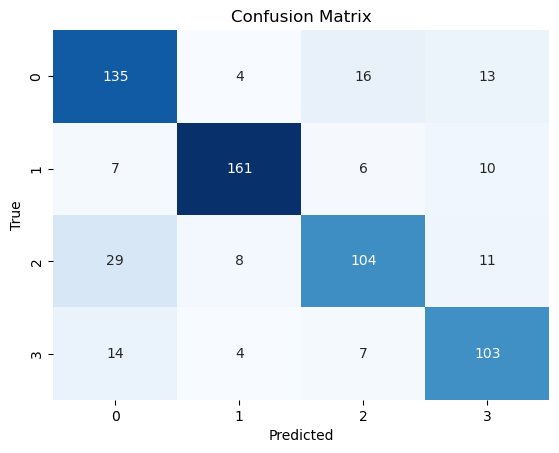

In [127]:
X_300 = pca_b4.transform(matriz_b4)[:,:300]

acc_b4 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_b4, pca_b4, 300, [64,10], 150, 100, graf=True)

acc_b4

### Estandarizado

Modelo con 2388, [64, 10], 80, 100
20/20 [==============================] - 0s 3ms/step - loss: 1.8036 - accuracy: 0.3471
34.719351679086685
Modelo con 2388, [64, 10], 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 3.1743 - accuracy: 0.3455
35.350821912288666
Modelo con 2388, [64, 10], 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 2.1152 - accuracy: 0.3170
34.63785573840141
Modelo con 2388, [64, 10], 150, 200
20/20 [==============================] - 0s 2ms/step - loss: 2.0195 - accuracy: 0.3059
33.57075825333595
Modelo con 2388, 100, 80, 100
20/20 [==============================] - 0s 3ms/step - loss: 2.9600 - accuracy: 0.4152
41.05291739106178
Modelo con 2388, 100, 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 2.9028 - accuracy: 0.3835
40.26102498173714
Modelo con 2388, 100, 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 2.6278 - accuracy: 0.4216
40.22178277373314
Modelo con 2388, 100, 150, 200

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


20/20 [==============================] - 0s 2ms/step
Modelo con 300, [64, 10], 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 1.3457 - accuracy: 0.6815
68.44815015792847
Modelo con 300, [64, 10], 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 1.1316 - accuracy: 0.7036
68.33023279905319
Modelo con 300, [64, 10], 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 1.0357 - accuracy: 0.7084
68.21112334728241
Modelo con 300, [64, 10], 150, 200
20/20 [==============================] - 0s 2ms/step - loss: 1.3524 - accuracy: 0.6815
67.97302812337875
Modelo con 300, 100, 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 1.2592 - accuracy: 0.7195
70.54679989814758
Modelo con 300, 100, 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 1.3450 - accuracy: 0.7036
69.00232434272766
Modelo con 300, 100, 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 1.2768 - accuracy: 0.7116
69.6

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


20/20 [==============================] - 0s 2ms/step


{'Kaiser': 0.4525316455696203, '300': 0.41930379746835444}

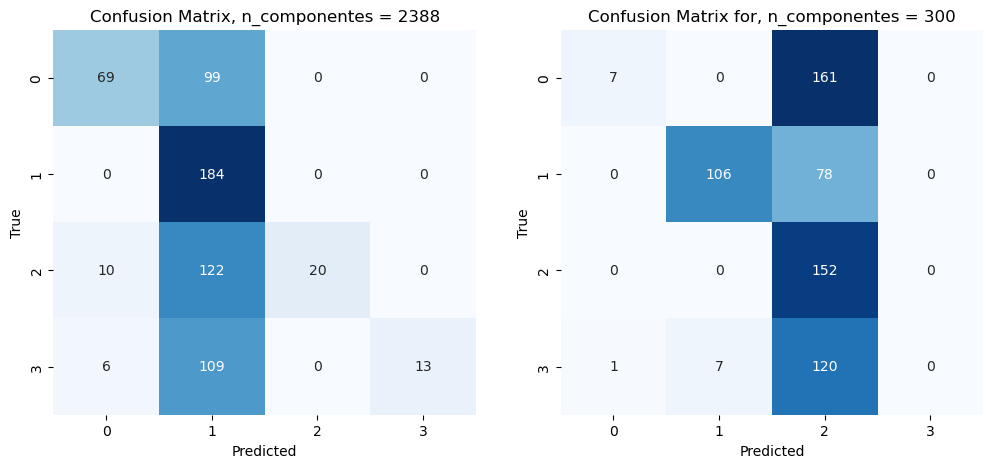

In [128]:
proceso_estandar(matriz_b4, y_train, X_val, y_val, tfidf_b4)

## Dos bloques: rec y sci

In [14]:
ng_ab = pd.concat([ng_b2, ng_b3], axis=0)

ng_ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7641 entries, 0 to 18262
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  7641 non-null   int64 
 1   Grupo         7641 non-null   object
 2   Documento     7641 non-null   object
 3   Target        7641 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 298.5+ KB


<AxesSubplot:xlabel='Grupo', ylabel='Count'>

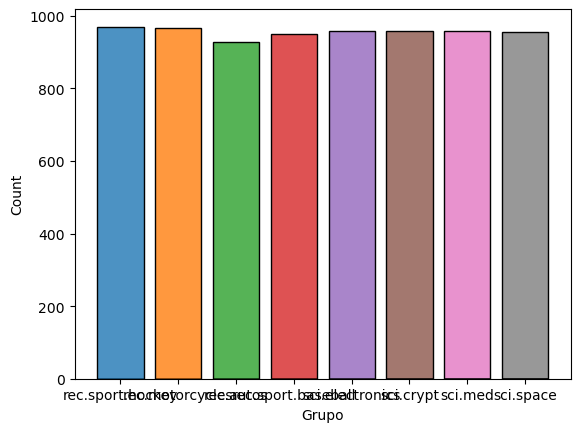

In [15]:
sns.histplot(data=ng_ab, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [16]:
set(ng_ab['Target'])

{7, 8, 9, 10, 11, 12, 13, 14}

In [17]:
y_encoded = [one_hot_encoding(target-7, 8) for target in ng_ab.iloc[:,3]]

In [18]:
X, y = ng_ab.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [19]:
len(X_train), len(X_val)

(6112, 1529)

Text(0.5, 1.0, 'X_val')

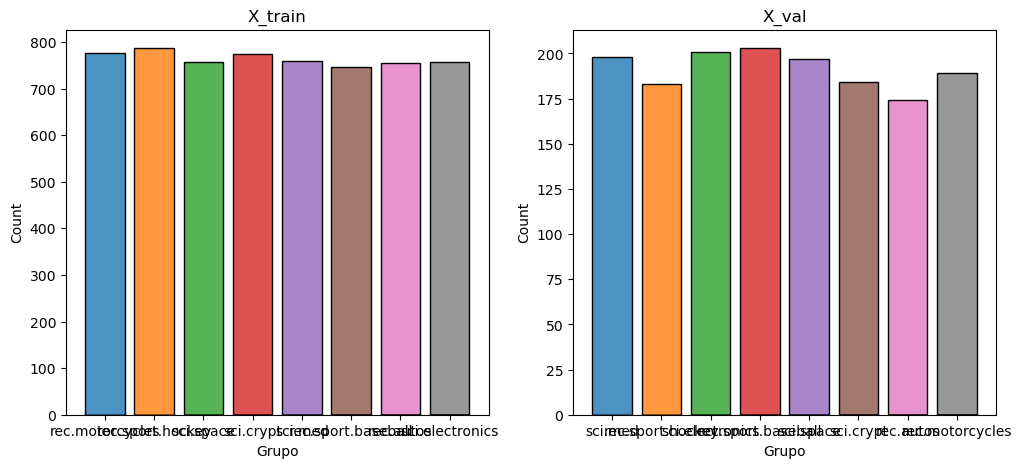

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [21]:
matriz_ab, tfidf_ab = tfidf(X_train)

matriz_ab.head()

,aa,aaa,aaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaarrrrgh,aaack,aaahh,aaai,aaaimit,aaamajor,...,zwak,zwakke,zware,zwarte,zwpq,zx,zxa,zygon,zzzzzz,zzzzzzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
matriz_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6112 entries, 0 to 6111
Columns: 35644 entries, aa to zzzzzzt
dtypes: float64(35644)
memory usage: 1.6 GB


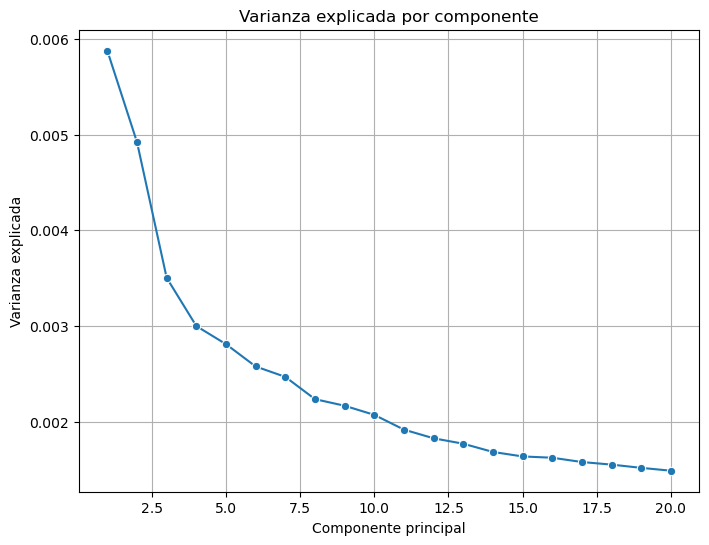

In [23]:
pca_ab, kaiser = pca(matriz_ab, graf=True)

**Método del codo:** 7 Componentes

In [24]:
n_componentes = 7
hidden_units = [9, 18]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_ab = grid_search(matriz_ab, y_train, pca_ab, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 7, 9, 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 1.0522 - accuracy: 0.6453
63.66164833307266
Modelo con 7, 9, 80, 200
48/48 [==============================] - 0s 2ms/step - loss: 1.1663 - accuracy: 0.6270
62.221859395504
Modelo con 7, 9, 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.9210 - accuracy: 0.6793
67.09751337766647
Modelo con 7, 9, 150, 200
48/48 [==============================] - 0s 2ms/step - loss: 1.0066 - accuracy: 0.6545
64.97054845094681
Modelo con 7, 18, 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.9669 - accuracy: 0.6564
66.52487069368362
Modelo con 7, 18, 80, 200
48/48 [==============================] - 0s 2ms/step - loss: 1.0604 - accuracy: 0.6394
63.64528685808182
Modelo con 7, 18, 150, 100
48/48 [==============================] - 0s 3ms/step - loss: 0.8961 - accuracy: 0.6793
68.22644025087357
Modelo con 7, 18, 150, 200
48/48 [==============================] - 0s 2ms/step - loss

In [25]:
dict(sorted(resultados_ab.items(), key=lambda item: item[1], reverse=True))

{(7, 18, 150, 100): 0.6822644025087357,
 (7, 9, 150, 100): 0.6709751337766647,
 (7, 18, 150, 200): 0.6701570600271225,
 (7, 18, 80, 100): 0.6652487069368362,
 (7, 9, 150, 200): 0.6497054845094681,
 (7, 9, 80, 100): 0.6366164833307266,
 (7, 18, 80, 200): 0.6364528685808182,
 (7, 9, 80, 200): 0.62221859395504}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


48/48 [==============================] - 0s 1ms/step


0.697841726618705

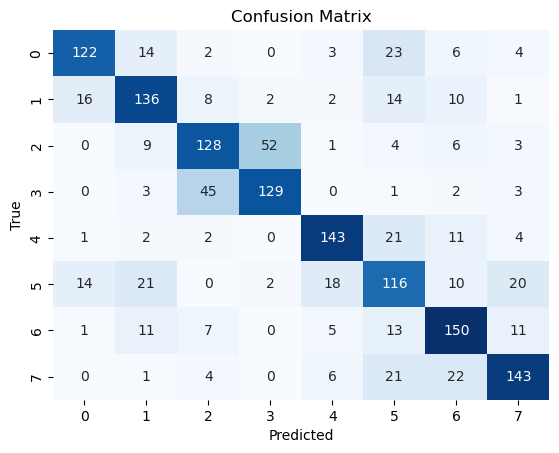

In [26]:
X_7 = pca_ab.transform(matriz_ab)[:,:7]

acc_codo = modelaje_final(X_7, y_train, X_val, y_val, tfidf_ab, pca_ab, 7, 18, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [27]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_ab = grid_search(matriz_ab, y_train, pca_ab, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 300, [64, 10], 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.8272
81.74083977937698
Modelo con 300, [64, 10], 80, 200
48/48 [==============================] - 0s 2ms/step - loss: 0.5662 - accuracy: 0.8181
81.65903091430664
Modelo con 300, [64, 10], 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.8174
81.65903091430664
Modelo con 300, [64, 10], 150, 200
48/48 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.8187
81.60994797945023
Modelo con 300, 100, 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.5099 - accuracy: 0.8397
83.13154429197311
Modelo con 300, 100, 80, 200
48/48 [==============================] - 0s 3ms/step - loss: 0.5234 - accuracy: 0.8318
82.42801278829575
Modelo con 300, 100, 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.5081 - accuracy: 0.8370
83.00065398216248
Modelo con 300, 100, 150, 200
48/48 [==

In [28]:
dict(sorted(resultados_ab.items(), key=lambda item: item[1], reverse=True))

{(300, 100, 80, 100): 0.8313154429197311,
 (300, 100, 150, 100): 0.8300065398216248,
 (300, 100, 150, 200): 0.8259162157773972,
 (300, 100, 80, 200): 0.8242801278829575,
 (300, (80, 20), 80, 100): 0.8231348097324371,
 (300, (80, 20), 150, 200): 0.8216623067855835,
 (300, (80, 20), 150, 100): 0.8196989595890045,
 (300, (80, 20), 80, 200): 0.8192081153392792,
 (300, (64, 10), 80, 100): 0.8174083977937698,
 (300, (64, 10), 80, 200): 0.8165903091430664,
 (300, (64, 10), 150, 100): 0.8165903091430664,
 (300, (64, 10), 150, 200): 0.8160994797945023}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


48/48 [==============================] - 0s 2ms/step


0.8443427076520602

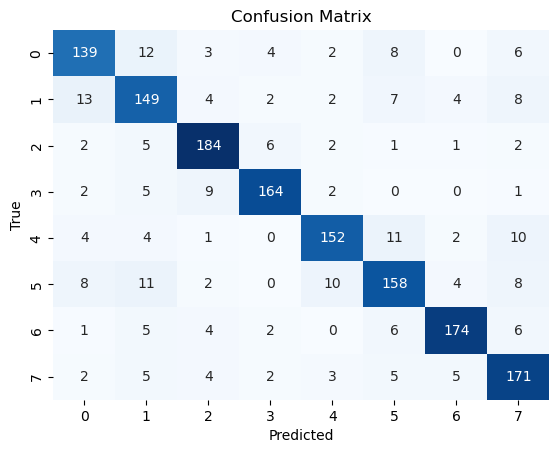

In [29]:
X_300 = pca_ab.transform(matriz_ab)[:,:300]

acc_ab = modelaje_final(X_300, y_train, X_val, y_val, tfidf_ab, pca_ab, 300, 100, 80, 100, graf=True)

acc_ab

### Estandarizado

Modelo con 5299, [64, 10], 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 2.0605 - accuracy: 0.4398
39.95418846607208
Modelo con 5299, [64, 10], 80, 200
48/48 [==============================] - 0s 2ms/step - loss: 1.9414 - accuracy: 0.4090
38.85798454284668
Modelo con 5299, [64, 10], 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 2.2529 - accuracy: 0.3757
40.068718045949936
Modelo con 5299, [64, 10], 150, 200
48/48 [==============================] - 0s 2ms/step - loss: 1.7707 - accuracy: 0.4791
38.301701098680496
Modelo con 5299, 100, 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 1.9670 - accuracy: 0.5072
49.509161710739136
Modelo con 5299, 100, 80, 200
48/48 [==============================] - 0s 2ms/step - loss: 2.0814 - accuracy: 0.4725
44.89528685808182
Modelo con 5299, 100, 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 2.1416 - accuracy: 0.4895
48.969241231679916
Modelo con 5299, 100, 150, 2

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


48/48 [==============================] - 0s 2ms/step
Modelo con 300, [64, 10], 80, 100
48/48 [==============================] - 0s 1ms/step - loss: 0.8209 - accuracy: 0.7742
76.11256539821625
Modelo con 300, [64, 10], 80, 200
48/48 [==============================] - 0s 1ms/step - loss: 0.8936 - accuracy: 0.7762
75.94895362854004
Modelo con 300, [64, 10], 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.9061 - accuracy: 0.7703
76.55431777238846
Modelo con 300, [64, 10], 150, 200
48/48 [==============================] - 0s 1ms/step - loss: 0.7933 - accuracy: 0.7834
75.75261741876602
Modelo con 300, 100, 80, 100
48/48 [==============================] - 0s 1ms/step - loss: 1.0129 - accuracy: 0.7821
77.40510553121567
Modelo con 300, 100, 80, 200
48/48 [==============================] - 0s 1ms/step - loss: 0.9109 - accuracy: 0.7873
77.79777497053146
Modelo con 300, 100, 150, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.9522 - accuracy: 0.7925
77.6

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


48/48 [==============================] - 0s 2ms/step


{'Kaiser': 0.6003924133420536, '300': 0.1458469587965991}

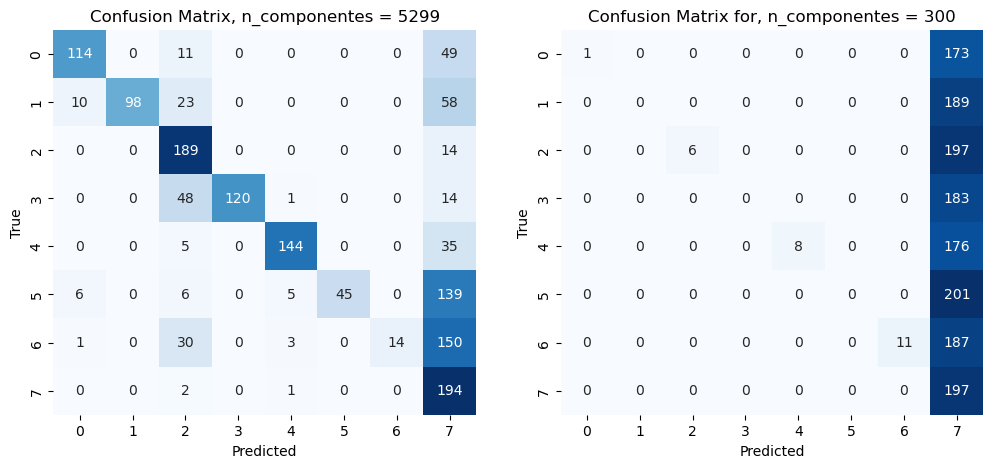

In [30]:
proceso_estandar(matriz_ab, y_train, X_val, y_val, tfidf_ab)

## Todo junto

<AxesSubplot:xlabel='Grupo', ylabel='Count'>

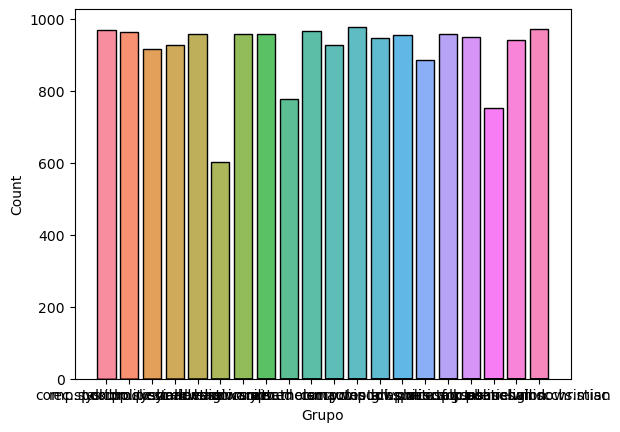

In [31]:
sns.histplot(data=ng_20, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)

In [32]:
y_encoded = [one_hot_encoding(target-1, 20) for target in ng_20.iloc[:,3]]

In [33]:
X, y = ng_20.drop(['Target'],axis=1), y_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [34]:
len(X_train), len(X_val)

(14612, 3654)

Text(0.5, 1.0, 'X_val')

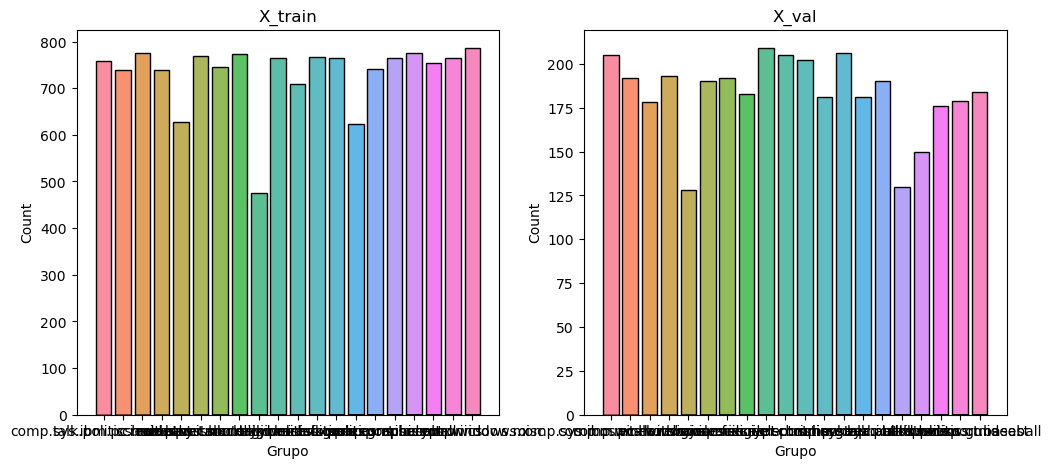

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.histplot(data=X_train, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_train')

plt.subplot(1,2,2)
sns.histplot(data=X_val, x="Grupo", hue="Grupo", shrink=.8, alpha=.8, legend=False)
plt.title('X_val')

In [36]:
matriz_20, tfidf_20 = tfidf(X_train)

matriz_20.head()

,aa,aaa,aaaaa,aaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaarrrrgh,aaaall,aaaggghhh,aaahh,aaahhhh,...,zyt,zyxel,zyyuhmmkp,zyzj,zzbfx,zzhlww,zzu,zzz,zzzzzz,zzzzzzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pca_20, kaiser = pca(matriz_20, n_max=300, graf=True)

MemoryError: Unable to allocate 9.05 GiB for an array with shape (14612, 83172) and data type float64

**Método del codo:** 11 Componentes

In [16]:
n_componentes = 11
hidden_units = [16, 32]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_20 = grid_search(matriz_20, y_train, pca_20, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 11, 16, 80, 100
69/69 [==============================] - 0s 1ms/step - loss: 1.6815 - accuracy: 0.4661
46.17312103509903
Modelo con 11, 16, 80, 200
69/69 [==============================] - 0s 1ms/step - loss: 1.7442 - accuracy: 0.4579
44.92027312517166
Modelo con 11, 16, 150, 100
69/69 [==============================] - 0s 1ms/step - loss: 1.6345 - accuracy: 0.4770
47.41457924246788
Modelo con 11, 16, 150, 200
69/69 [==============================] - 0s 1ms/step - loss: 1.6567 - accuracy: 0.4692
47.072893381118774
Modelo con 11, 32, 80, 100
69/69 [==============================] - 0s 1ms/step - loss: 1.6367 - accuracy: 0.4697
47.17539921402931
Modelo con 11, 32, 80, 200
69/69 [==============================] - 0s 1ms/step - loss: 1.6892 - accuracy: 0.4670
46.9476081430912
Modelo con 11, 32, 150, 100
69/69 [==============================] - 0s 1ms/step - loss: 1.5929 - accuracy: 0.4843
48.84965866804123
Modelo con 11, 32, 150, 200
69/69 [==============================] - 0s 1

In [17]:
dict(sorted(resultados_20.items(), key=lambda item: item[1], reverse=True))

{(11, 32, 150, 100): 0.4884965866804123,
 (11, 32, 150, 200): 0.4760819971561432,
 (11, 16, 150, 100): 0.4741457924246788,
 (11, 32, 80, 100): 0.4717539921402931,
 (11, 16, 150, 200): 0.47072893381118774,
 (11, 32, 80, 200): 0.469476081430912,
 (11, 16, 80, 100): 0.4617312103509903,
 (11, 16, 80, 200): 0.4492027312517166}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


69/69 [==============================] - 0s 1ms/step


0.503872437357631

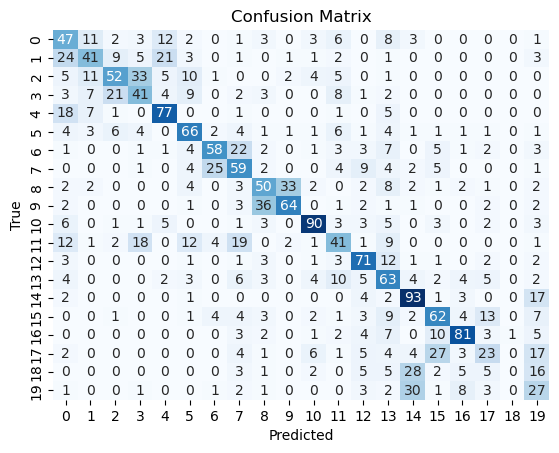

In [20]:
X_11 = pca_20.transform(matriz_20)[:,:11]

acc_codo = modelaje_final(X_11, y_train, X_val, y_val, tfidf_20, pca_20, 11, 32, 150, 100, graf=True)

acc_codo

**Método de la misma dimensión**: 300 Componentes

In [18]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_20 = grid_search(matriz_20, y_train, pca_20, n_componentes, hidden_units, epochs, batch_sizes, resultados_20)

Modelo con 300, [64, 10], 80, 100
69/69 [==============================] - 0s 2ms/step - loss: 1.2594 - accuracy: 0.6446
64.63553607463837
Modelo con 300, [64, 10], 80, 200
69/69 [==============================] - 0s 2ms/step - loss: 1.2175 - accuracy: 0.6433
64.37357664108276
Modelo con 300, [64, 10], 150, 100
69/69 [==============================] - 0s 2ms/step - loss: 1.2299 - accuracy: 0.6465
64.69248235225677
Modelo con 300, [64, 10], 150, 200
69/69 [==============================] - 0s 1ms/step - loss: 1.2648 - accuracy: 0.6255
63.64464610815048
Modelo con 300, 100, 80, 100
69/69 [==============================] - 0s 2ms/step - loss: 1.0908 - accuracy: 0.6838
68.21184456348419
Modelo con 300, 100, 80, 200
69/69 [==============================] - 0s 1ms/step - loss: 1.0990 - accuracy: 0.6866
68.22323501110077
Modelo con 300, 100, 150, 100
69/69 [==============================] - 0s 2ms/step - loss: 1.0884 - accuracy: 0.6825
68.35990846157074
Modelo con 300, 100, 150, 200
69/69 [==

In [19]:
dict(sorted(resultados_20.items(), key=lambda item: item[1], reverse=True))

{(300, 100, 150, 100): 0.6835990846157074,
 (300, 100, 80, 200): 0.6822323501110077,
 (300, 100, 80, 100): 0.6821184456348419,
 (300, 100, 150, 200): 0.6807517111301422,
 (300, (80, 20), 150, 100): 0.663211852312088,
 (300, (80, 20), 80, 200): 0.6600227802991867,
 (300, (80, 20), 80, 100): 0.6589977145195007,
 (300, (80, 20), 150, 200): 0.6567198187112808,
 (300, (64, 10), 150, 100): 0.6469248235225677,
 (300, (64, 10), 80, 100): 0.6463553607463837,
 (300, (64, 10), 80, 200): 0.6437357664108276,
 (300, (64, 10), 150, 200): 0.6364464610815048,
 (11, 32, 150, 100): 0.4884965866804123,
 (11, 32, 150, 200): 0.4760819971561432,
 (11, 16, 150, 100): 0.4741457924246788,
 (11, 32, 80, 100): 0.4717539921402931,
 (11, 16, 150, 200): 0.47072893381118774,
 (11, 32, 80, 200): 0.469476081430912,
 (11, 16, 80, 100): 0.4617312103509903,
 (11, 16, 80, 200): 0.4492027312517166}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


69/69 [==============================] - 0s 1ms/step


0.696127562642369

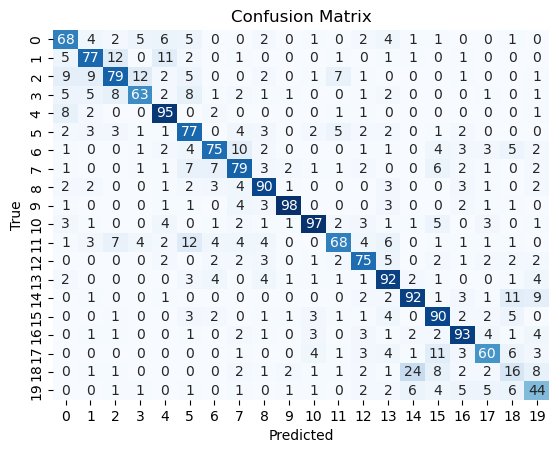

In [21]:
X_300 = pca_20.transform(matriz_20)[:,:300]

acc_20 = modelaje_final(X_300, y_train, X_val, y_val, tfidf_20, pca_20, 300, 100, 150, 100, graf=True)

acc_20

### Estandarizado

In [55]:
estandar_20 = (matriz_20-np.mean(matriz_20, axis=0))/np.std(matriz_20, axis=0)

In [24]:
estandar_20.shape

(8780, 66872)

In [56]:
pca_estandar_20, kaiser = pca(estandar_20, n_max=300)

In [58]:
pca_estandar_20.explained_variance_[-1]

21.127762689823072

In [59]:
n_componentes = 300
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

resultados_20 = grid_search(estandar_20, y_train, pca_estandar_20, n_componentes, hidden_units, epochs, batch_sizes, {})

Modelo con 300, [64, 10], 80, 100
69/69 [==============================] - 0s 2ms/step - loss: 2.2399 - accuracy: 0.4674
46.68564945459366
Modelo con 300, [64, 10], 80, 200
69/69 [==============================] - 0s 2ms/step - loss: 2.1145 - accuracy: 0.4583
44.70387250185013
Modelo con 300, [64, 10], 150, 100
69/69 [==============================] - 0s 3ms/step - loss: 2.0651 - accuracy: 0.4533
47.47152552008629
Modelo con 300, [64, 10], 150, 200
69/69 [==============================] - 0s 2ms/step - loss: 2.0230 - accuracy: 0.4642
47.14123010635376
Modelo con 300, 100, 80, 100
69/69 [==============================] - 0s 2ms/step - loss: 2.1158 - accuracy: 0.5467
54.999999701976776
Modelo con 300, 100, 80, 200
69/69 [==============================] - 0s 2ms/step - loss: 2.3228 - accuracy: 0.5426
55.239179730415344
Modelo con 300, 100, 150, 100
69/69 [==============================] - 0s 2ms/step - loss: 2.2578 - accuracy: 0.5194
54.74943071603775
Modelo con 300, 100, 150, 200
69/69 [

In [60]:
dict(sorted(resultados_20.items(), key=lambda item: item[1], reverse=True))

{(300, 100, 80, 200): 0.5523917973041534,
 (300, 100, 80, 100): 0.5499999970197678,
 (300, 100, 150, 100): 0.5474943071603775,
 (300, 100, 150, 200): 0.5458997637033463,
 (300, (80, 20), 80, 200): 0.5134396255016327,
 (300, (80, 20), 150, 100): 0.5132118463516235,
 (300, (80, 20), 150, 200): 0.5109339356422424,
 (300, (80, 20), 80, 100): 0.5063781291246414,
 (300, (64, 10), 150, 100): 0.4747152552008629,
 (300, (64, 10), 150, 200): 0.4714123010635376,
 (300, (64, 10), 80, 100): 0.4668564945459366,
 (300, (64, 10), 80, 200): 0.4470387250185013}

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


69/69 [==============================] - 0s 2ms/step


0.14578587699316628

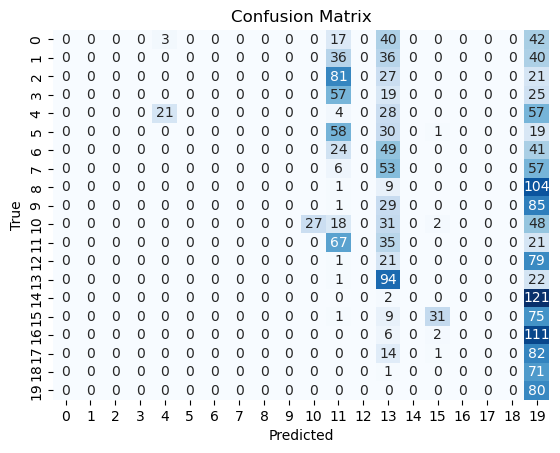

In [61]:
X_300_estandar = pca_estandar_20.transform(estandar_20)[:,:300]

acc_20_estandar = modelaje_final(X_300_estandar, y_train, X_val, y_val, tfidf_20, pca_estandar_20, 300, 100, 80, 200, graf=True)

acc_20_estandar

Modelo con 3427, [64, 10], 80, 100
29/29 [==============================] - 0s 2ms/step - loss: 2.7031 - accuracy: 0.2793
24.184782803058624
Modelo con 3427, [64, 10], 80, 200
29/29 [==============================] - 0s 2ms/step - loss: 2.7600 - accuracy: 0.2370
24.42934773862362
Modelo con 3427, [64, 10], 150, 100
29/29 [==============================] - 0s 4ms/step - loss: 2.3718 - accuracy: 0.2011
23.614130169153214
Modelo con 3427, [64, 10], 150, 200
29/29 [==============================] - 0s 2ms/step - loss: 2.5637 - accuracy: 0.2196
24.076087400317192
Modelo con 3427, 100, 80, 100
29/29 [==============================] - 0s 2ms/step - loss: 2.8361 - accuracy: 0.3663
35.135868936777115
Modelo con 3427, 100, 80, 200
29/29 [==============================] - 0s 2ms/step - loss: 2.9207 - accuracy: 0.3457
32.98913016915321
Modelo con 3427, 100, 150, 100
29/29 [==============================] - 0s 2ms/step - loss: 2.6500 - accuracy: 0.3957
36.5760862827301
Modelo con 3427, 100, 150, 20

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


29/29 [==============================] - 0s 2ms/step
Modelo con 300, [64, 10], 80, 100
29/29 [==============================] - 0s 2ms/step - loss: 0.8279 - accuracy: 0.7663
75.43478310108185
Modelo con 300, [64, 10], 80, 200
29/29 [==============================] - 0s 2ms/step - loss: 0.9663 - accuracy: 0.7511
75.0543475151062
Modelo con 300, [64, 10], 150, 100
29/29 [==============================] - 0s 3ms/step - loss: 0.9431 - accuracy: 0.7717
75.43478310108185
Modelo con 300, [64, 10], 150, 200
29/29 [==============================] - 0s 2ms/step - loss: 1.0081 - accuracy: 0.7620
74.8913049697876
Modelo con 300, 100, 80, 100
29/29 [==============================] - 0s 4ms/step - loss: 1.0149 - accuracy: 0.7750
77.90760695934296
Modelo con 300, 100, 80, 200
29/29 [==============================] - 0s 2ms/step - loss: 0.9927 - accuracy: 0.7826
77.63586938381195
Modelo con 300, 100, 150, 100
29/29 [==============================] - 0s 2ms/step - loss: 1.0011 - accuracy: 0.7815
77.663

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


29/29 [==============================] - 0s 1ms/step


{'Kaiser': 0.5163043478260869, '300': 0.17065217391304346}

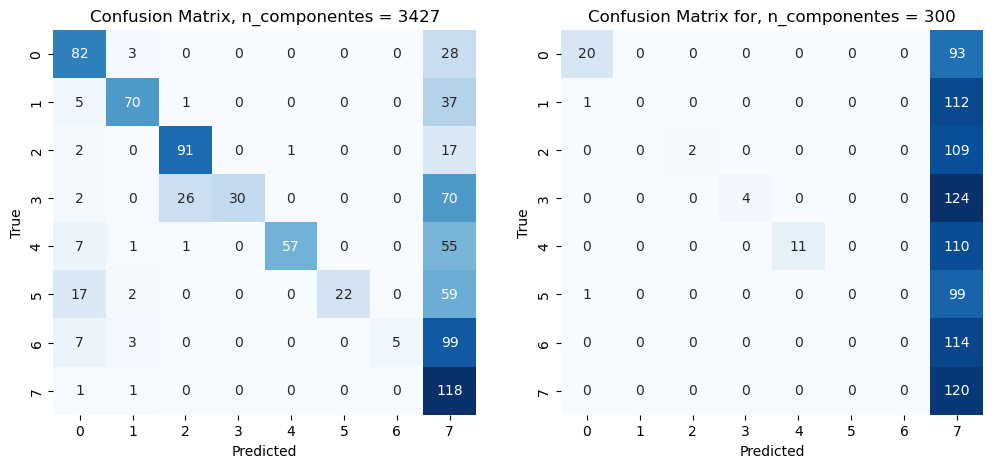

In [79]:
proceso_estandar(matriz_ab, y_train, X_val, y_val, tfidf_ab)

## Dimensiones de las matrices

In [39]:
print(f'Conjunto: ateauto, dimensiones: {matriz_ateauto.shape}')
print(f'Conjunto: a4, dimensiones: {matriz_a4.shape}')
print(f'Conjunto: b1, dimensiones: {matriz_b1.shape}')
print(f'Conjunto: b2, dimensiones: {matriz_b2.shape}')
print(f'Conjunto: b3, dimensiones: {matriz_b3.shape}')
print(f'Conjunto: b4, dimensiones: {matriz_b4.shape}')
print(f'Conjunto: ab, dimensiones: {matriz_ab.shape}')
print(f'Conjunto: 20, dimensiones: {matriz_20.shape}')

Conjunto: ateauto, dimensiones: (820, 9313)
Conjunto: a4, dimensiones: (1787, 19618)
Conjunto: b1, dimensiones: (2281, 29647)
Conjunto: b2, dimensiones: (1833, 15735)
Conjunto: b3, dimensiones: (1846, 20384)
Conjunto: b4, dimensiones: (1512, 19578)
Conjunto: ab, dimensiones: (3680, 29844)
Conjunto: 20, dimensiones: (8780, 66872)
